# HCAA Testing and creation of portfolios

Ideas:
- Calcularles el IPR a los 12 portafolios

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import kneed
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from sklearn.metrics import calinski_harabasz_score
from hcaa_implementation import hcaa_alocation
import rie_estimator
import csestimator
import typing as t
from urllib.request import urlopen
import certifi
import json

## Definition of aux functions

In [20]:
def get_optimal_k_eigen(corr_matrix, N, T):
    eigenvals = np.linalg.eigvals(corr_matrix)
    count = (eigenvals > 1 + 2 * np.sqrt(N / T) + N / T).sum()
    return count

def get_optimal_k_calenski(dataset, bottom_range, top_range, corr_function):
    corr_mat = corr_function(dataset.T)
    D_matrix = np.sqrt(2 * (1 - corr_mat))
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, "ward", optimal_ordering=True)
    indices = []
    for i in range(bottom_range, top_range):
        labels = fcluster(Z, i, criterion="maxclust")
        indices.append(calinski_harabasz_score(dataset.T, labels))
    # pd.Series(indices).plot()
    print(
        kneed.KneeLocator(
            range(bottom_range, top_range),
            indices,
            curve="convex",
            direction="decreasing",
        ).knee
    )
    return kneed.KneeLocator(
        range(bottom_range, top_range), indices, curve="convex", direction="decreasing"
    ).knee


def get_optimal_k_calenski_rie(dataset, bottom_range, top_range, corr_function):
    corr_mat = corr_function(dataset)
    D_matrix = np.sqrt(2 * (1 - corr_mat))
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, "ward", optimal_ordering=True)
    indices = []
    for i in range(bottom_range, top_range):
        labels = fcluster(Z, i, criterion="maxclust")
        indices.append(calinski_harabasz_score(dataset.T, labels))
    print(
        kneed.KneeLocator(
            range(bottom_range, top_range),
            indices,
            curve="convex",
            direction="decreasing",
        ).knee
    )
    return kneed.KneeLocator(
        range(bottom_range, top_range), indices, curve="convex", direction="decreasing"
    ).knee

def get_levels(n_clusters: int, n_filas: int, mat_Z: np.matrix):
    nodos_id = []
    nivel_nodo = []
    filas_Z = mat_Z.shape[0]
    current_bif = mat_Z[-1]
    nodos_id.append(int(current_bif[0]))
    nivel_nodo.append(.5)
    nodos_id.append(int(current_bif[1]))
    nivel_nodo.append(.5)
    current_level = 2
    while(current_level < n_clusters):
        id_cluster = filas_Z+n_filas-current_level
        current_bif = mat_Z[-current_level]
        index_of_id = nodos_id.index(id_cluster)
        new_weight = nivel_nodo[index_of_id] / 2
        del nivel_nodo[index_of_id]
        del nodos_id[index_of_id]
        nodos_id.append(int(current_bif[0]))
        nivel_nodo.append(new_weight)
        nodos_id.append(int(current_bif[1]))
        nivel_nodo.append(new_weight)
        current_level += 1
    return(nodos_id, nivel_nodo)

## Reading and selecting data

In [21]:
precios_americano = pd.read_csv(
    "./sp_500_original_clean.csv",
    index_col="Date",
    parse_dates=True,
)

precios_europeo = pd.read_csv(
    "./european_market_original_clean.csv",
    index_col="Date",
    parse_dates=True,
)

retornos_american = (np.log(precios_americano) - np.log(precios_americano.shift(1))).iloc[1:]
retornos_europeo = (np.log(precios_europeo) - np.log(precios_europeo.shift(1))).iloc[1:]


Determinación de la última ventana de tiempo para ambos mercados

In [22]:
ultima_ventana_american = retornos_american[retornos_american.shape[0] - (retornos_american.shape[1]*2):]
ultima_ventana_european = retornos_europeo[retornos_europeo.shape[0] - (retornos_europeo.shape[1]*2):]

Los periodos comprendidos entre las ventanas son los siguientes:

Mercado americano: 2018-05-09 a 2021-12-30

Mercado europeo: 2019-10-17 a 2021-12-10

Reviso que el ratio óptimo para el RIE se mantenga, notando que sea de 1/2:

In [23]:
print(ultima_ventana_european.shape[1]/ultima_ventana_european.shape[0])
print(ultima_ventana_american.shape[1]/ultima_ventana_american.shape[0])

0.5
0.5


## Determinación de número óptimo de grupos

### Valores Propios

In [24]:
rie_estimator_american = rie_estimator.get_rie(ultima_ventana_american, True, True)
pearson_estimator_american = np.corrcoef(ultima_ventana_american.values.T)
eca_estimator_american = csestimator.get_shrinkage_est(ultima_ventana_american, alpha = 0.5)

k_optimal_eigen_american_rie = get_optimal_k_eigen(rie_estimator_american, ultima_ventana_american.shape[0], ultima_ventana_american.shape[1])
k_optimal_eigen_american_pearson = get_optimal_k_eigen(pearson_estimator_american, ultima_ventana_american.shape[0], ultima_ventana_american.shape[1])
k_optimal_eigen_american_eca = get_optimal_k_eigen(eca_estimator_american, ultima_ventana_american.shape[0], ultima_ventana_american.shape[1])

print('MERCADO AMERICANO')
print(k_optimal_eigen_american_rie)
print(k_optimal_eigen_american_pearson)
print(k_optimal_eigen_american_eca)


MERCADO AMERICANO
6
5
9


In [43]:
rie_estimator_european = rie_estimator.get_rie(ultima_ventana_european, False, True)
pearson_estimator_european = np.corrcoef(ultima_ventana_european.values.T)
eca_estimator_european = csestimator.get_shrinkage_est(ultima_ventana_european, alpha = 0.5)

k_optimal_eigen_european_rie = get_optimal_k_eigen(rie_estimator_european, ultima_ventana_european.shape[0], ultima_ventana_european.shape[1])
k_optimal_eigen_european_pearson = get_optimal_k_eigen(pearson_estimator_european, ultima_ventana_european.shape[0], ultima_ventana_european.shape[1])
k_optimal_eigen_european_eca = get_optimal_k_eigen(eca_estimator_european, ultima_ventana_european.shape[0], ultima_ventana_european.shape[1])

print('MERCADO EUROPEO')
print(k_optimal_eigen_european_rie)
print(k_optimal_eigen_european_pearson)
print(k_optimal_eigen_european_eca)

MERCADO EUROPEO
3
3
4


### Calenski

In [27]:
k_optimal_calenski_american_rie = get_optimal_k_calenski_rie(ultima_ventana_american, 2, 50, rie_estimator.get_rie)
k_optimal_calenski_american_pearson = get_optimal_k_calenski(ultima_ventana_american, 2, 50, np.corrcoef)
k_optimal_calenski_american_eca = get_optimal_k_calenski(ultima_ventana_american, 2, 50, np.corrcoef)

14
6
6


In [28]:
k_optimal_calenski_european_rie = get_optimal_k_calenski_rie(ultima_ventana_european, 2, 50, rie_estimator.get_rie)
k_optimal_calenski_european_pearson = get_optimal_k_calenski(ultima_ventana_european, 2, 50, np.corrcoef)
k_optimal_calenski_european_eca = get_optimal_k_calenski(ultima_ventana_european, 2, 50, np.corrcoef)

10
8
8


## DENDOGRAM

## Mercado Americano

In [40]:
def get_levels(n_clusters: int, n_filas: int, mat_Z: np.matrix):
    nodos_id = []
    nivel_nodo = []
    filas_Z = mat_Z.shape[0]
    current_bif = mat_Z[-1]
    nodos_id.append(int(current_bif[0]))
    nivel_nodo.append(.5)
    nodos_id.append(int(current_bif[1]))
    nivel_nodo.append(.5)
    current_level = 2
    while(current_level < n_clusters):
        id_cluster = filas_Z+n_filas-current_level
        current_bif = mat_Z[-current_level]
        index_of_id = nodos_id.index(id_cluster)
        new_weight = nivel_nodo[index_of_id] / 2
        del nivel_nodo[index_of_id]
        del nodos_id[index_of_id]
        nodos_id.append(int(current_bif[0]))
        nivel_nodo.append(new_weight)
        nodos_id.append(int(current_bif[1]))
        nivel_nodo.append(new_weight)
        current_level += 1
    distance_threshold = current_bif[2] - 0.000001
    return(nodos_id, nivel_nodo, distance_threshold)

def hacer_dendograma(data_set: pd.DataFrame, corr_est_func: t.Callable, link_name: str, num_grupos: int):
    E_matrix = corr_est_func(data_set)
    D_matrix = np.sqrt(2*(1- E_matrix))
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, link_name, optimal_ordering = True)
    fig = plt.figure(figsize=(35, 15))
    _, _, distancia = get_levels(num_grupos, data_set.shape[1], Z)
    dn = dendrogram(Z, color_threshold= distancia, labels=data_set.columns.to_numpy())
    return dn 


REVISADO .ME QUEDO ACÁ, HAY QUE USAR UNA VERSIÓN MODIFICADA DE GET_LEVELS PARA QUE REGRESE EL THRESHOLD (ESTE THRESHOLD HAY QUE REDONDEARLO UN POCO HACIA ABAJO) Y ESE THRESHOLD ES EL QUE HAY QUE USAR EN EL DENDOGRAMA PARA QUE SE COLOREEN CORRECTAMENTE LOS GRUPOS. 

REVISADO.  NOTAR QUE EL ENLACE DE WARD PUEDE PRODUCIR VALORES MAYORES A 2 PUES ESTÁ USANDO UNA FUNCIÓN PARA CALCULAR LA DISTANCIA ENTRE CLUSTERS (NO TIENE POR QUE ESTAR DENTRO DEL BOUND DE LA DISTANCIA DE MANTEGNA). SI SE USA OTRO ENLACE EN DONDE LA FUNCIÓN SEA SELECCIONAR LA DISTANCIA MÁXIMA O MÍNIMA ENTRE DOS PUNTOS DEL CLUSTES, ENTONCES LOS BOUNDS DE MANTEGNA SÍ SE TIENEN QUE RESPETAR, Y DE HECHO SÍ SE RESPETAN, COMO SE MUESTRA A CONTINUACIÓN. 

ME QUEDO INVESTIGANDO EXACTAMENTE CUAL ES LA IMPLEMENTACIÓN DEL ENLACE DE WARD QUE SE UTILIZA EN SCIPY. 

### RIE

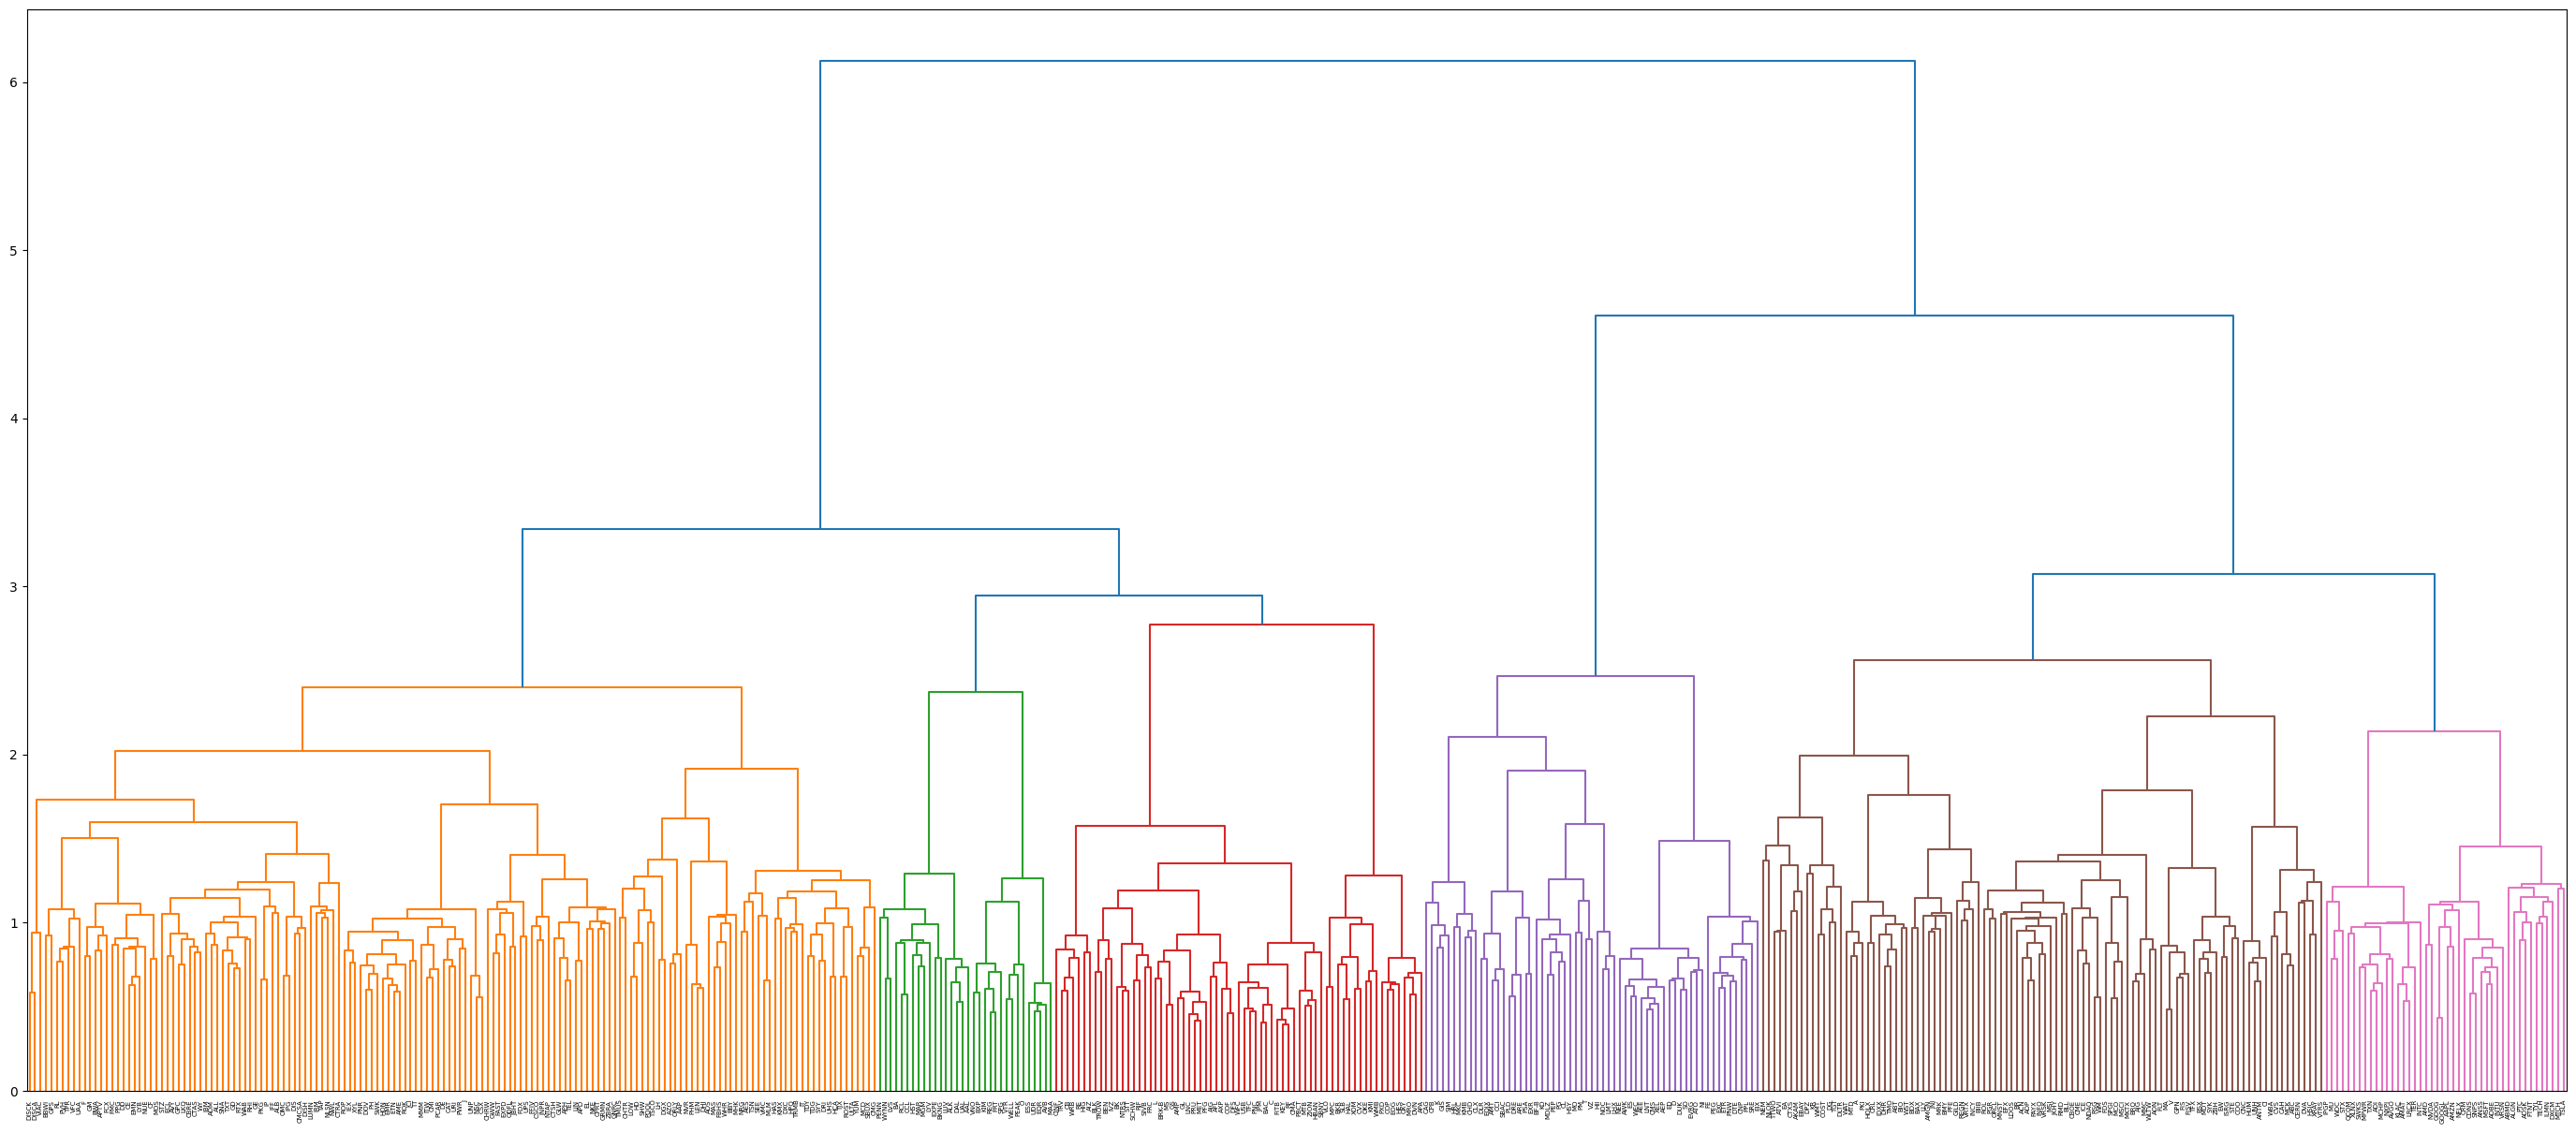

In [13]:
hacer_dendograma(ultima_ventana_american, rie_estimator.get_rie, 'ward', k_optimal_eigen_american_rie);

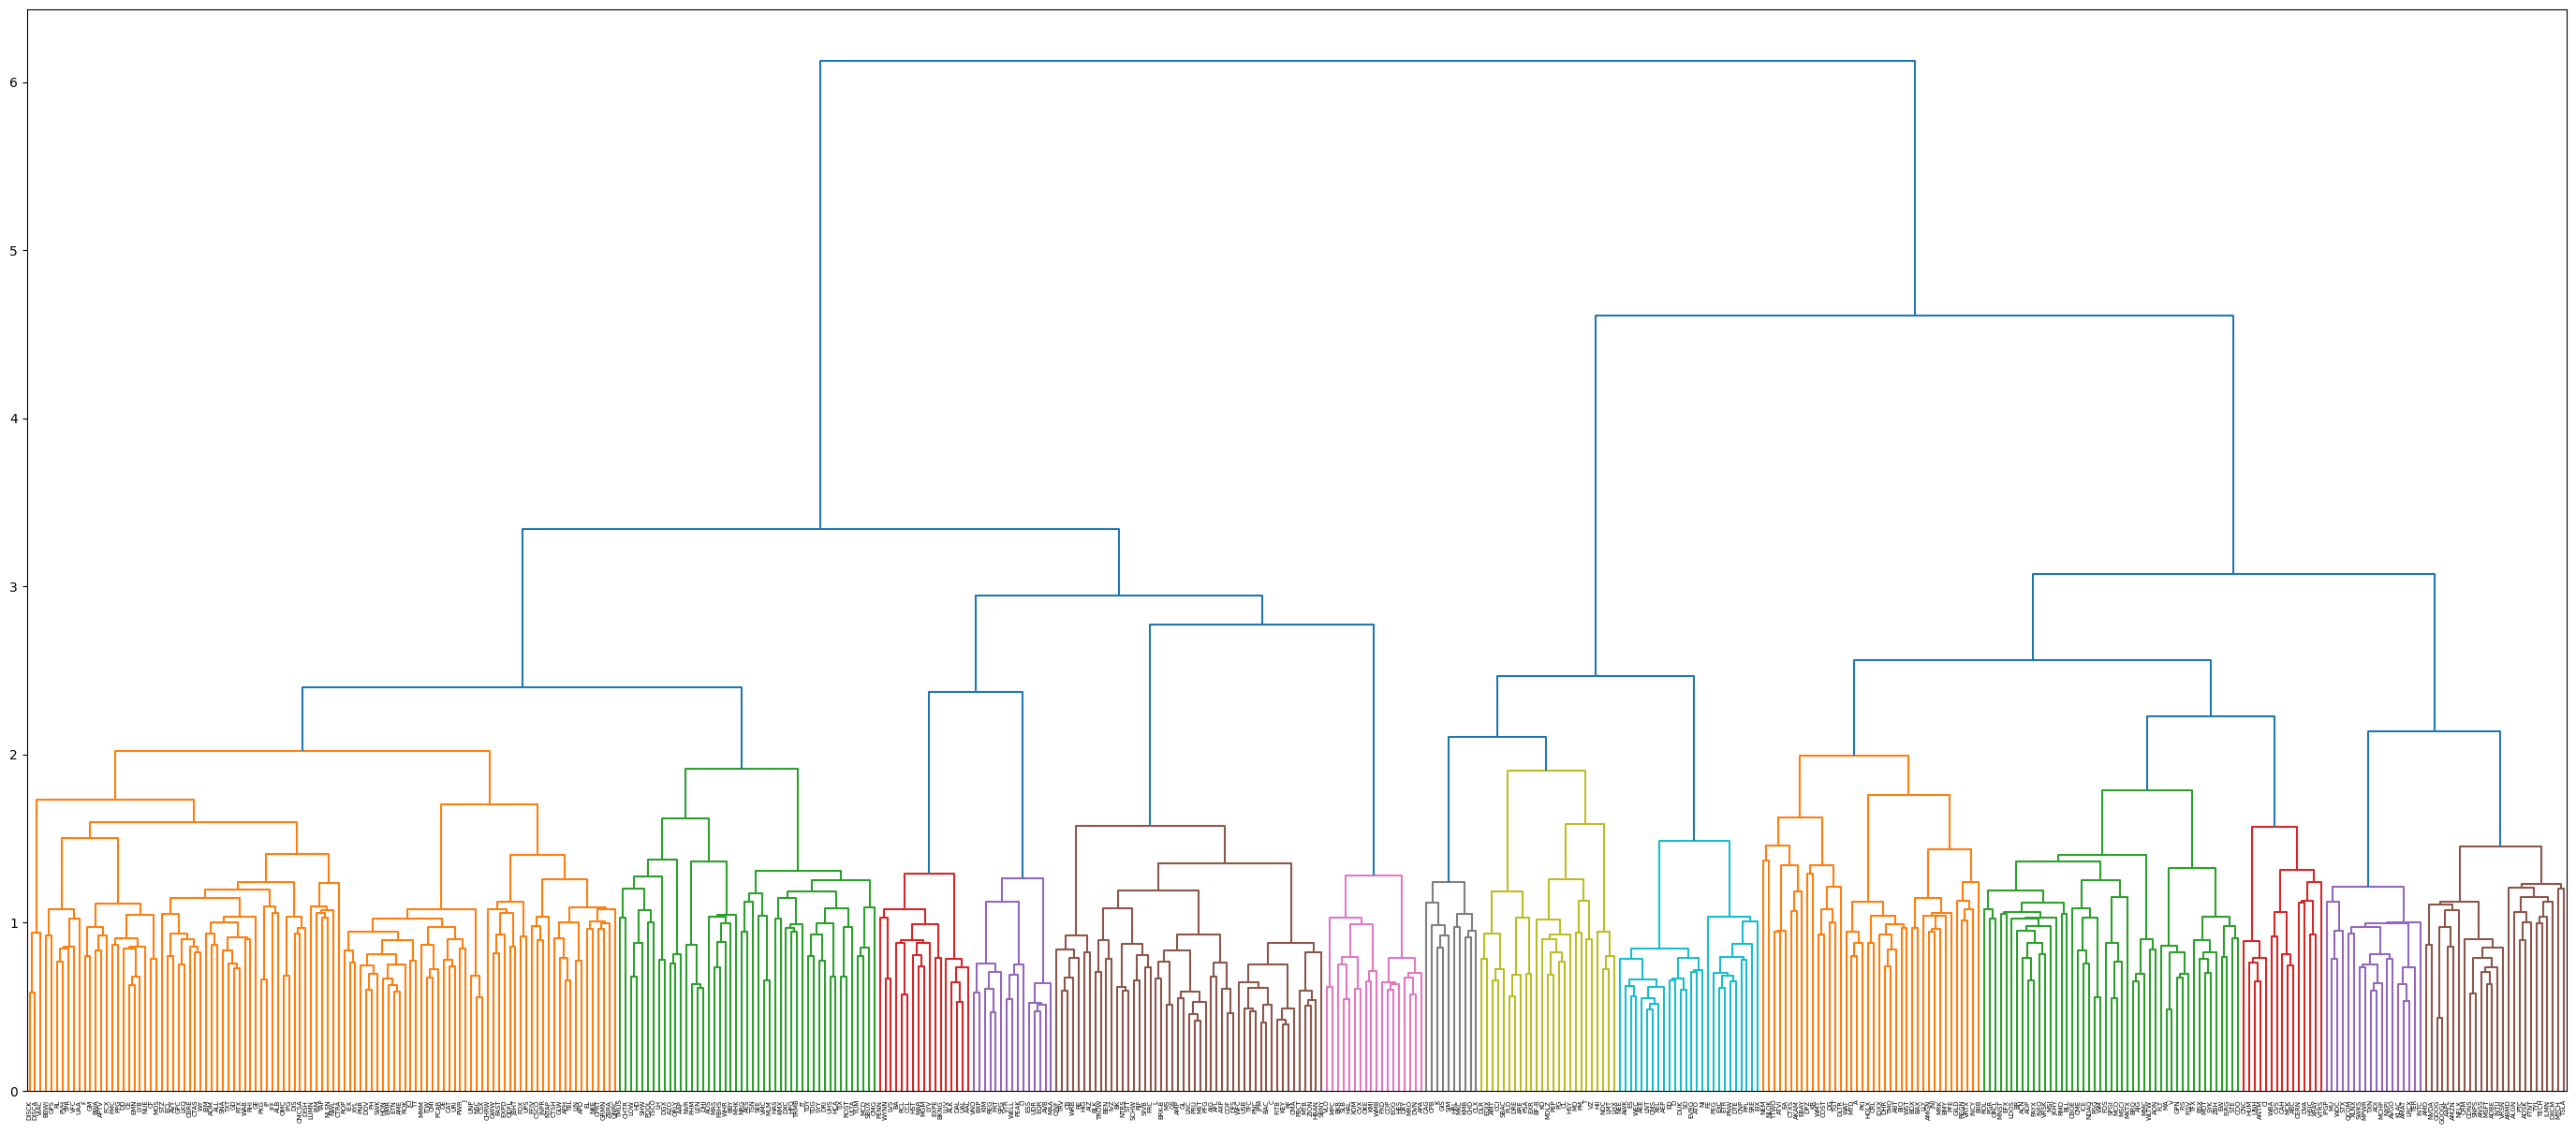

In [14]:
hacer_dendograma(ultima_ventana_american, rie_estimator.get_rie, 'ward', k_optimal_calenski_american_rie);

### ECA

In [15]:
def wrapper_eca(X, alpha=0.5):
    return csestimator.get_shrinkage_est(X, alpha)

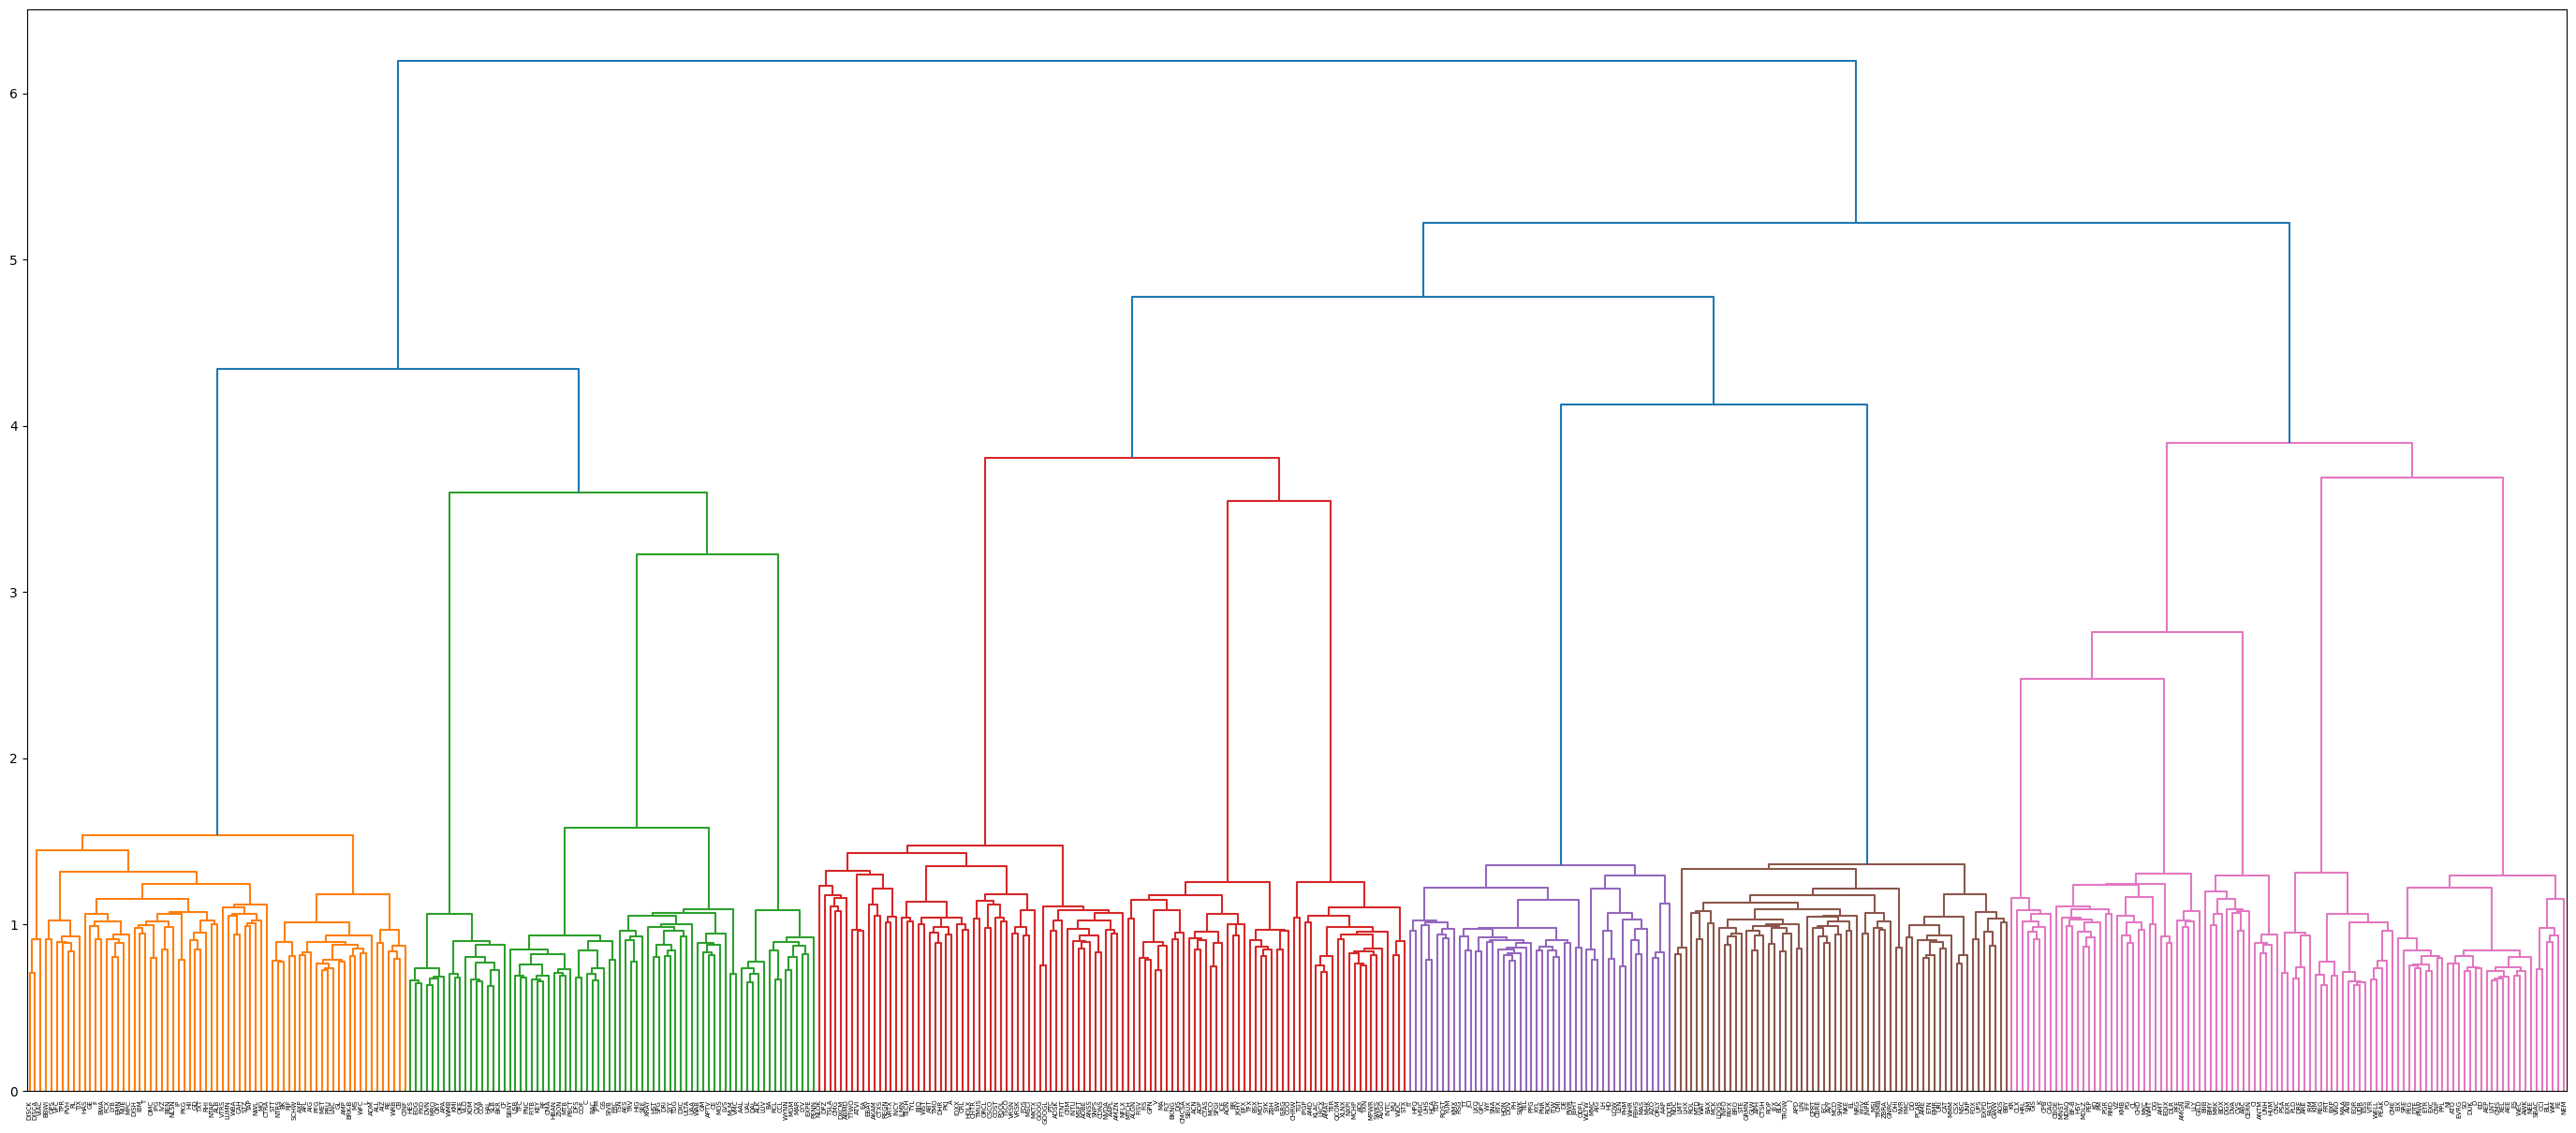

In [17]:
hacer_dendograma(ultima_ventana_american, wrapper_eca, 'ward', k_optimal_calenski_american_eca);

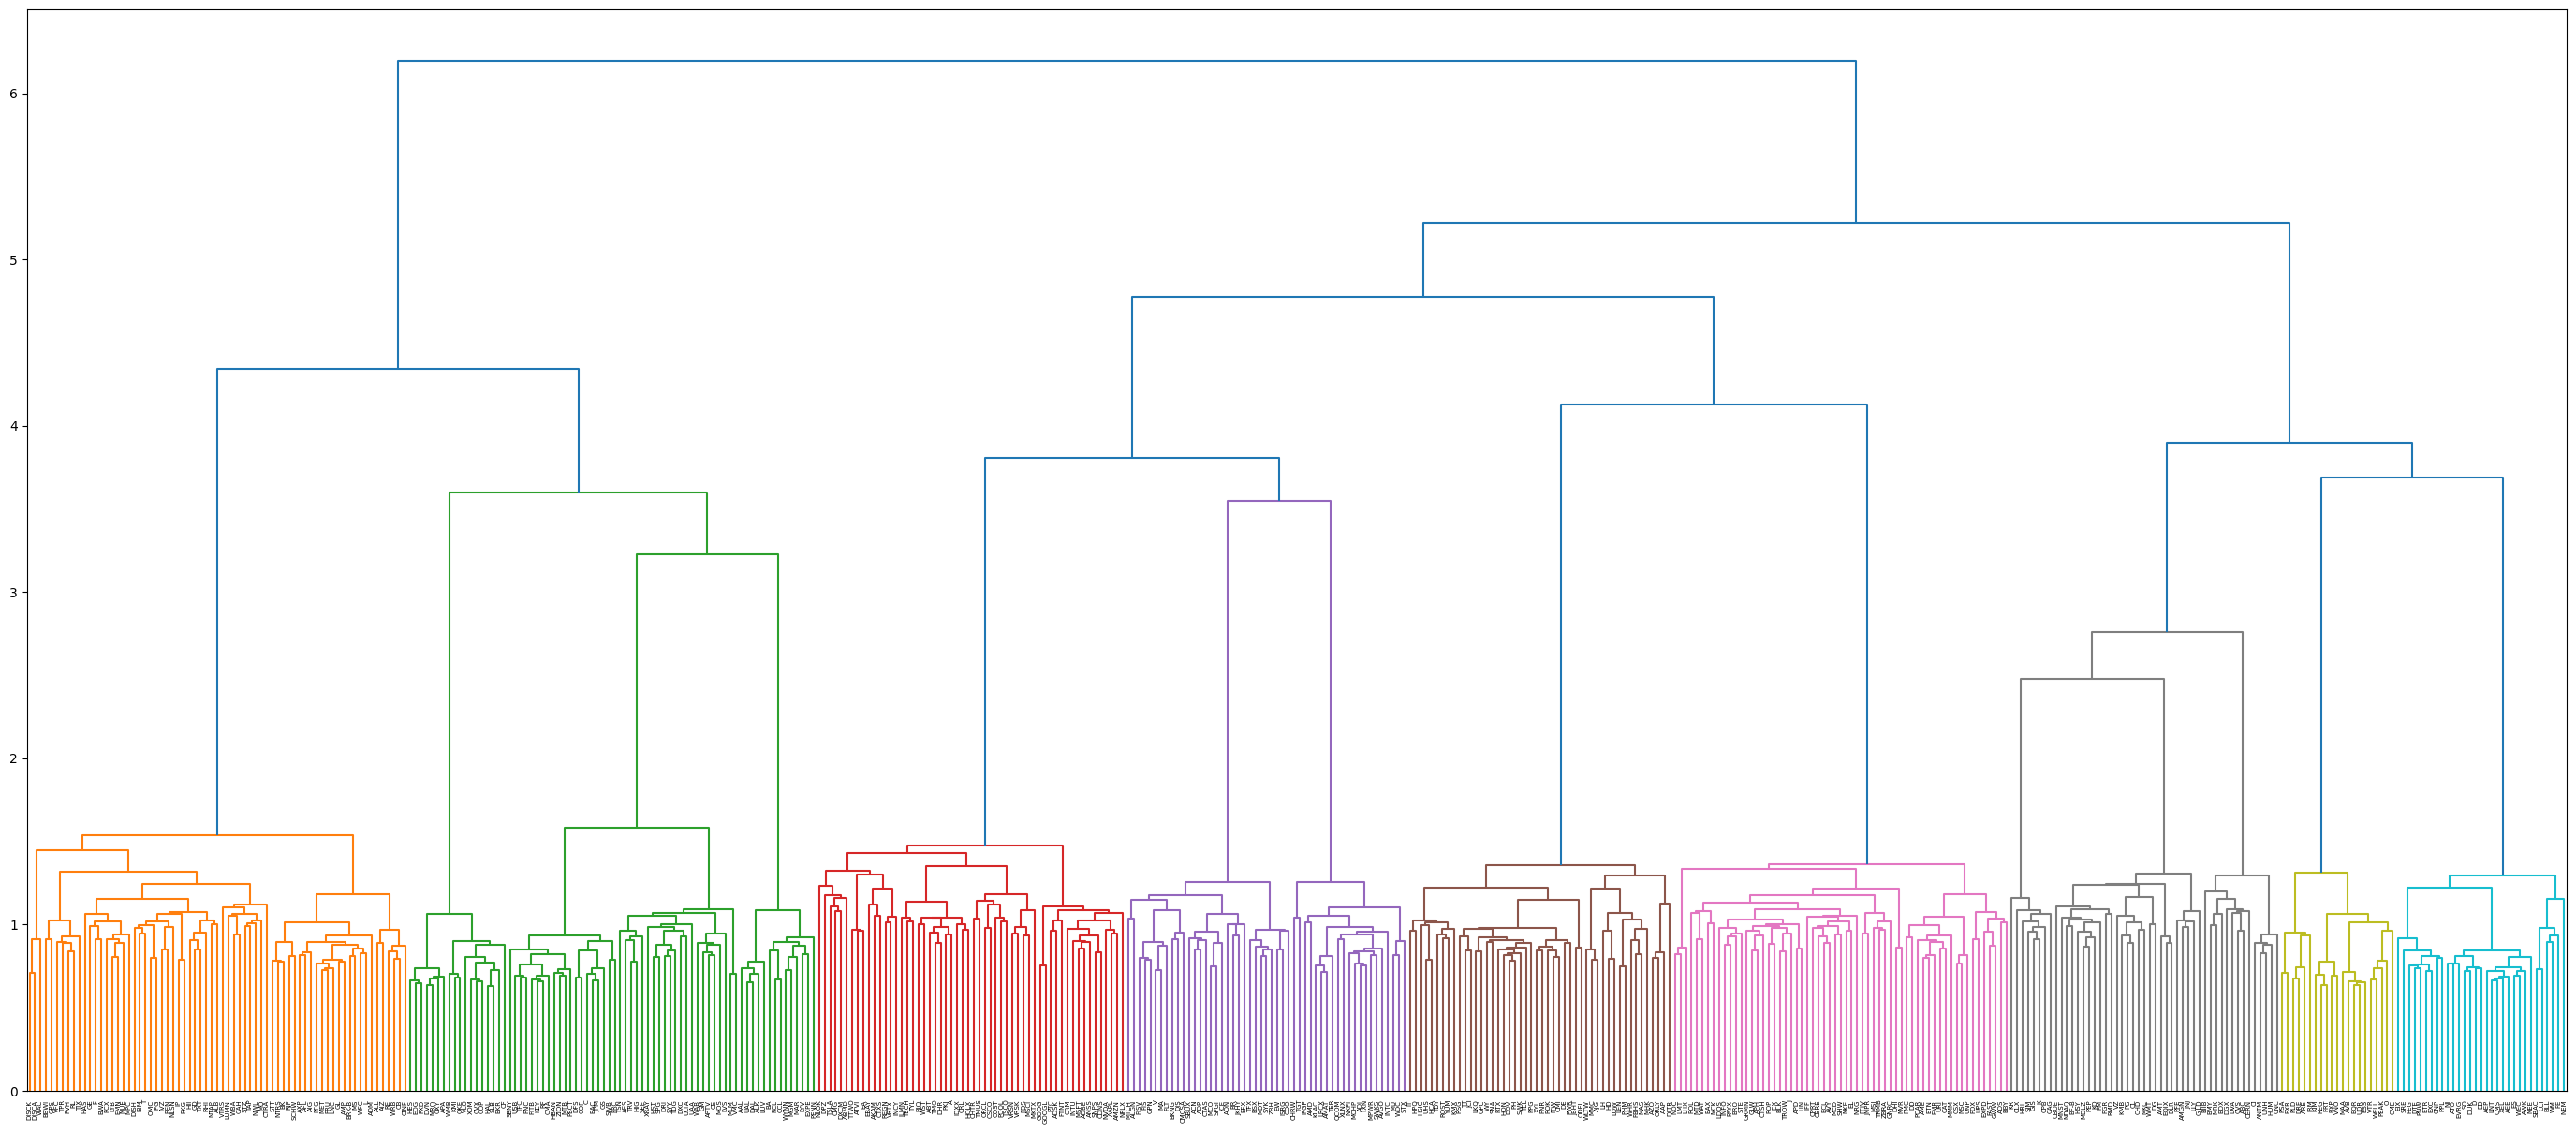

In [18]:
hacer_dendograma(ultima_ventana_american, wrapper_eca, 'ward', k_optimal_eigen_american_eca);

### PEARSON

In [38]:
def wrapper_pearson(X):
    return np.corrcoef(X.T)

(460, 460)


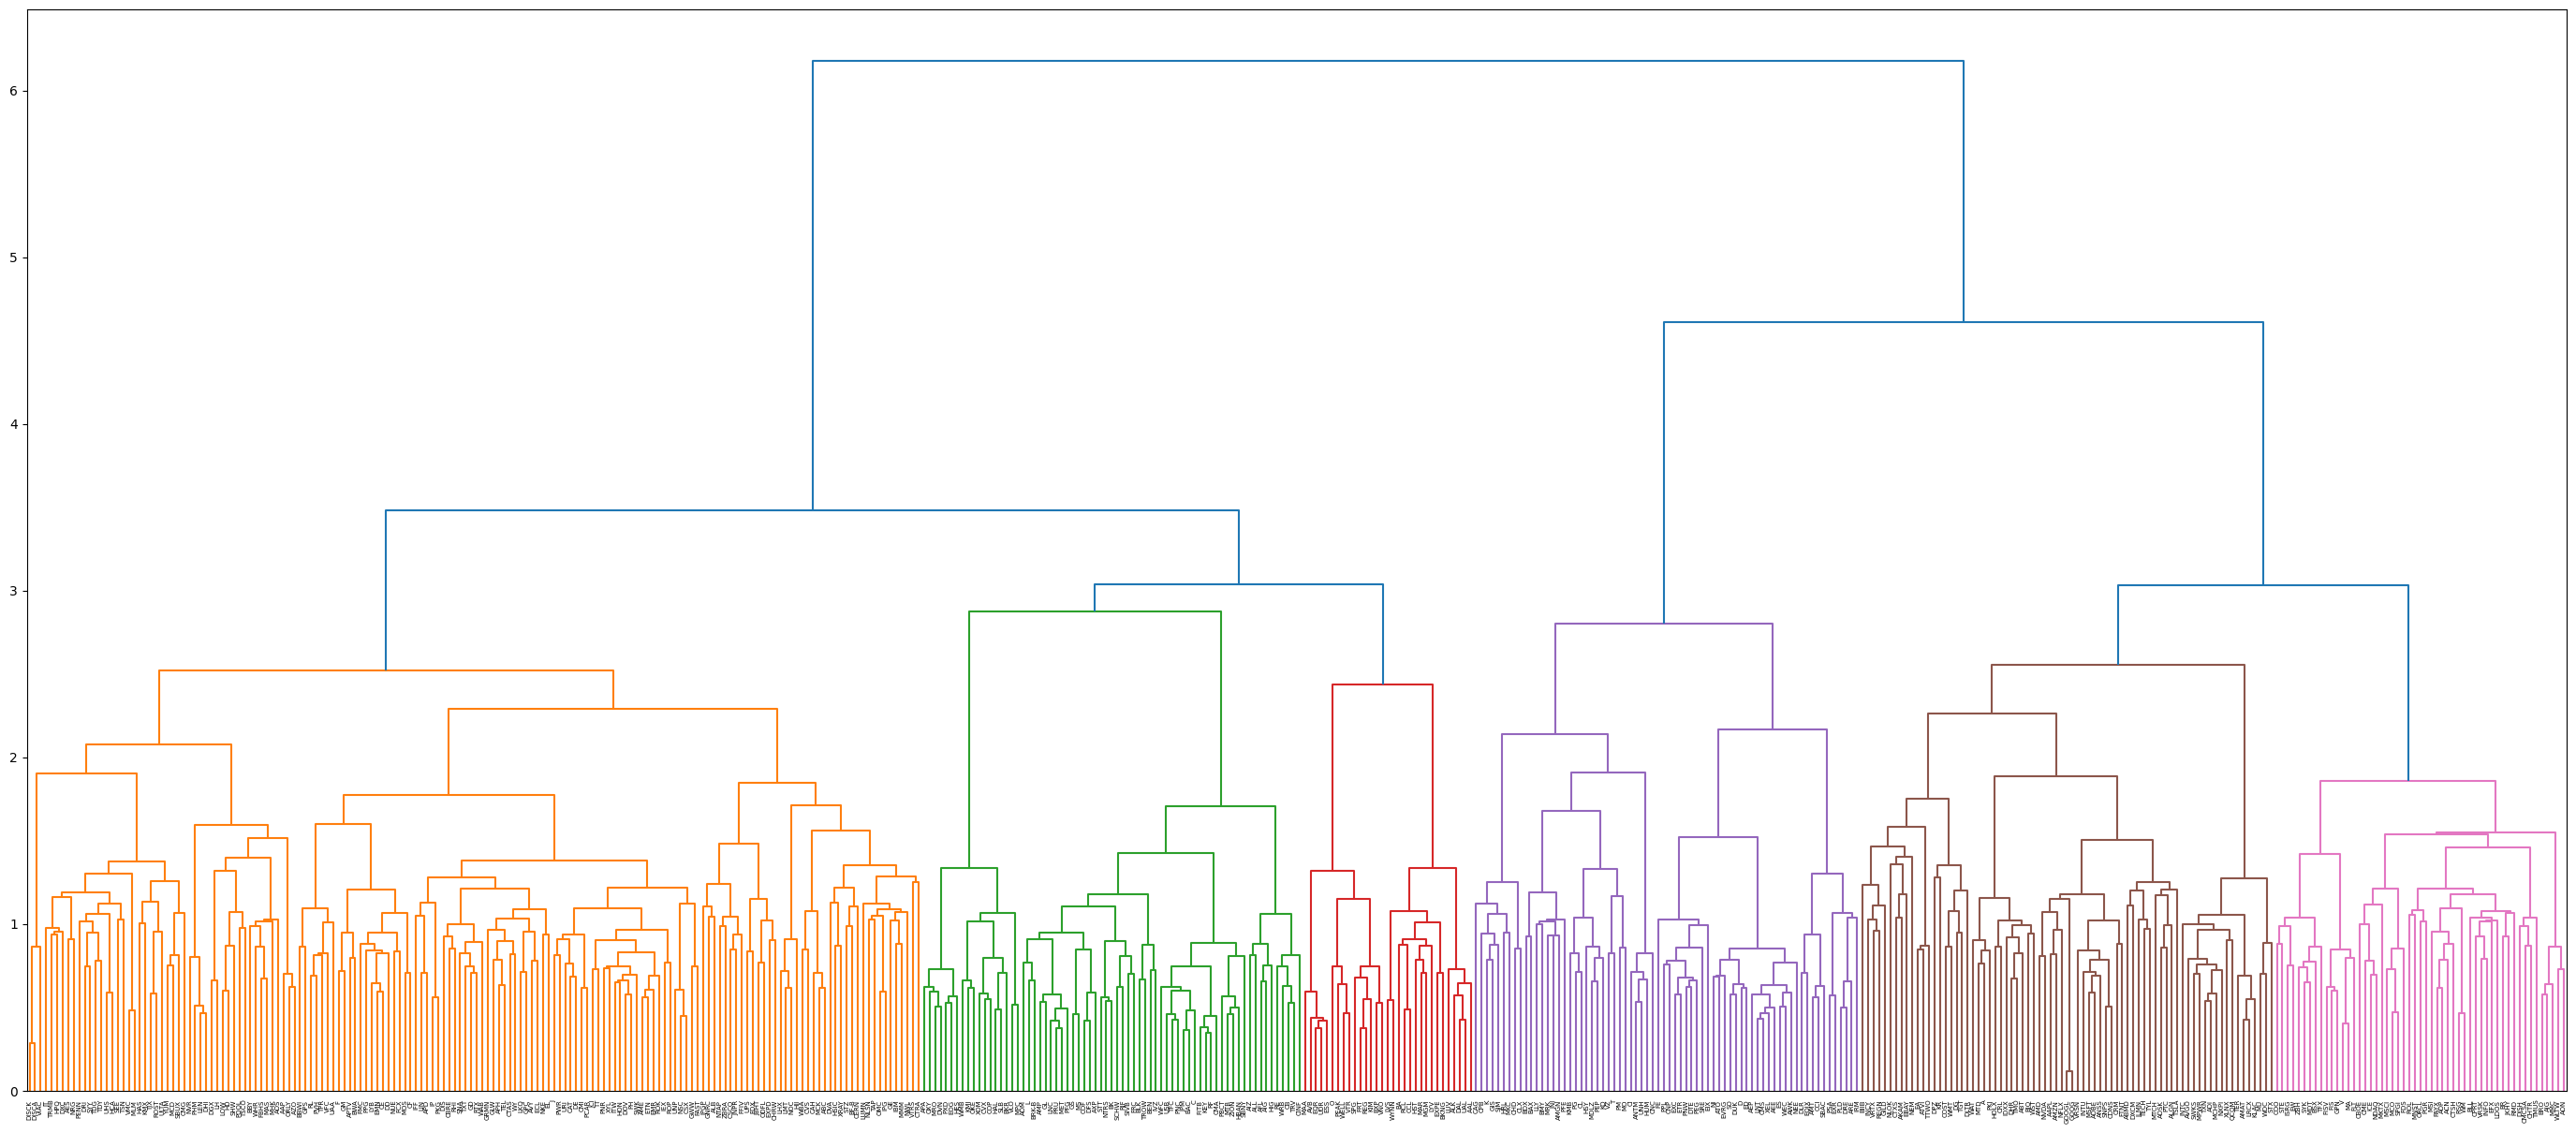

In [39]:
hacer_dendograma(ultima_ventana_american, wrapper_pearson, 'ward', k_optimal_calenski_american_pearson);

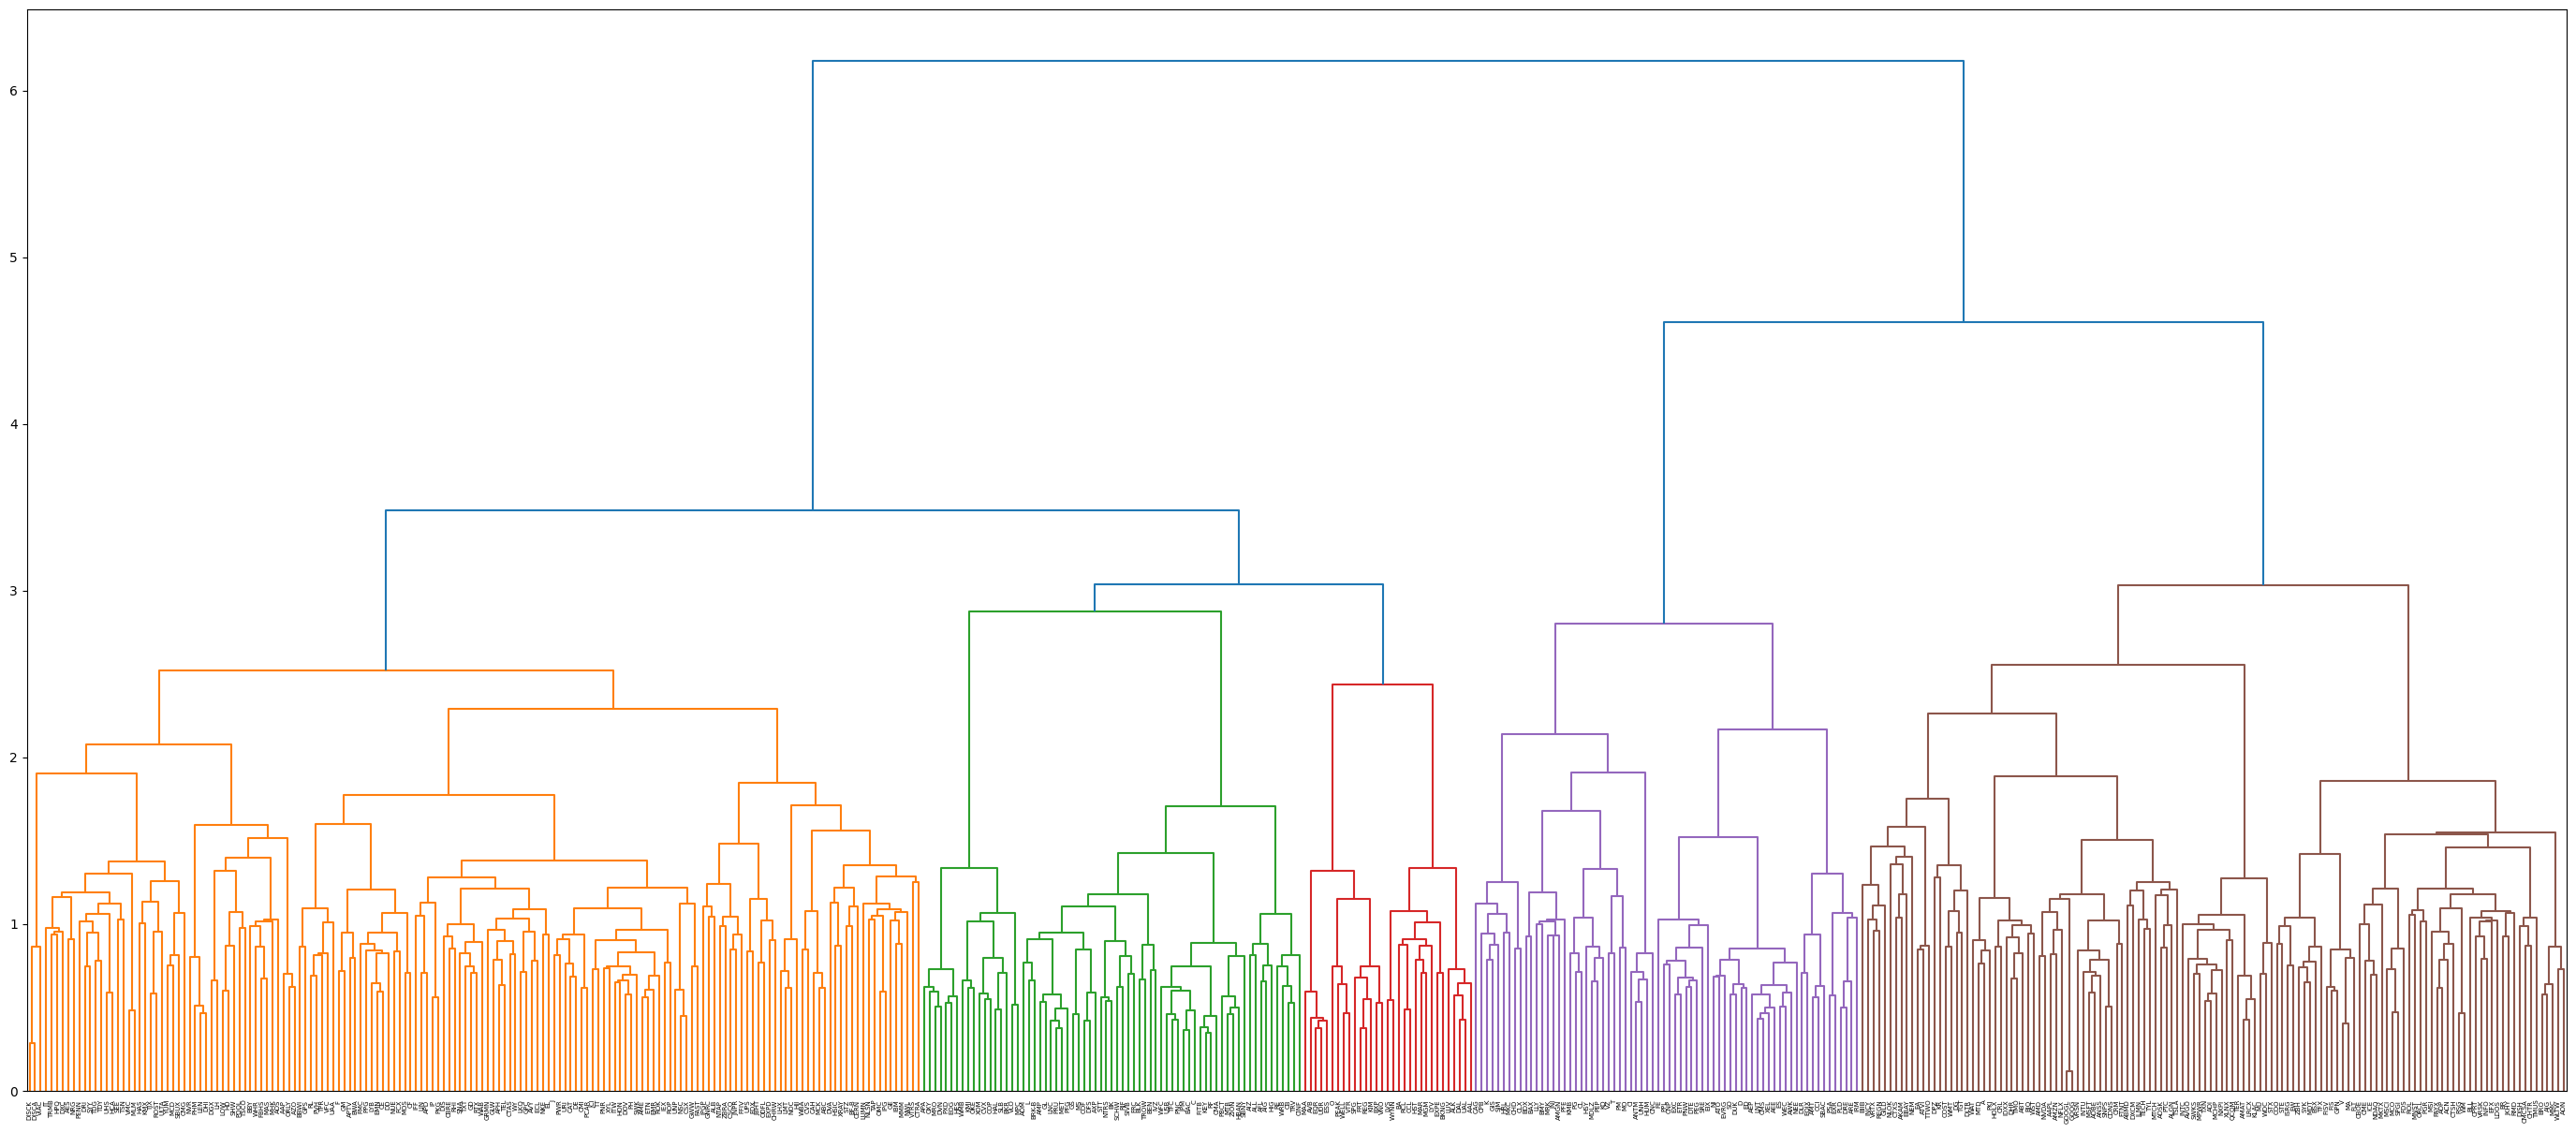

In [41]:
hacer_dendograma(ultima_ventana_american, wrapper_pearson, 'ward', k_optimal_eigen_american_pearson);

## MERCADO EUROPEO

### RIE

In [50]:
ultima_ventana_european

,AD.AS,AGN.AS,AKZA.AS,ASM.AS,ASML.AS,BESI.AS,DSM.AS,HEIA.AS,INGA.AS,KPN.AS,...,NOVN.SW,PGHN.SW,ROG.SW,SCMN.SW,SGSN.SW,SIKA.SW,SLHN.SW,SREN.SW,UBSG.SW,ZURN.SW
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-17,0.003682,-0.001290,0.000476,-0.010720,-0.013877,0.001296,0.016185,0.006322,-0.006286,0.009501,...,-0.003014,0.006561,0.009406,-0.006354,0.002844,0.007144,0.010665,0.002443,-0.008014,-0.002309
2019-10-18,-0.006290,0.005408,-0.000833,-0.006111,-0.004376,-0.003892,-0.007829,-0.007345,0.001182,0.001013,...,-0.007341,-0.008933,0.003289,0.009516,-0.005696,-0.008392,-0.004703,0.003411,0.000000,-0.005667
2019-10-21,-0.005892,0.011490,-0.015476,0.027437,0.021478,0.013878,-0.006494,-0.009258,0.019490,-0.010514,...,-0.004336,-0.001056,0.000346,0.000789,0.004884,0.012099,0.003274,0.005820,0.022979,0.011302
2019-10-22,-0.002191,0.007083,-0.013389,-0.015719,-0.004949,0.017160,-0.006068,-0.000413,-0.001159,-0.000682,...,0.009469,-0.005298,-0.001729,0.008638,0.006878,-0.001543,-0.004915,0.000000,0.000000,-0.002045
2019-10-23,-0.002416,0.013769,0.019656,-0.002566,-0.007578,0.000945,-0.009880,-0.031935,-0.002322,0.000341,...,-0.005600,-0.014986,0.000173,0.002733,0.001612,-0.004333,0.003893,-0.004847,0.006966,-0.001537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-06,0.009740,0.016382,0.010784,-0.042951,-0.027986,-0.048143,0.008373,0.034271,0.015504,0.003882,...,0.014305,-0.000684,0.014525,0.002359,0.022543,0.020648,0.023635,0.014194,0.017808,0.017231
2021-12-07,0.016409,0.015148,0.007808,0.082609,0.079764,0.069259,0.029776,0.016275,0.012423,0.006950,...,0.002944,0.027686,0.001903,0.001570,0.015314,0.018894,-0.002192,0.000224,0.013902,0.004071
2021-12-08,-0.015908,-0.010482,-0.011114,-0.022357,-0.016727,-0.007992,-0.001012,-0.037500,-0.006670,0.000769,...,-0.000401,0.016513,0.012548,-0.007084,-0.003722,-0.000535,0.002557,-0.002015,-0.001201,-0.004071


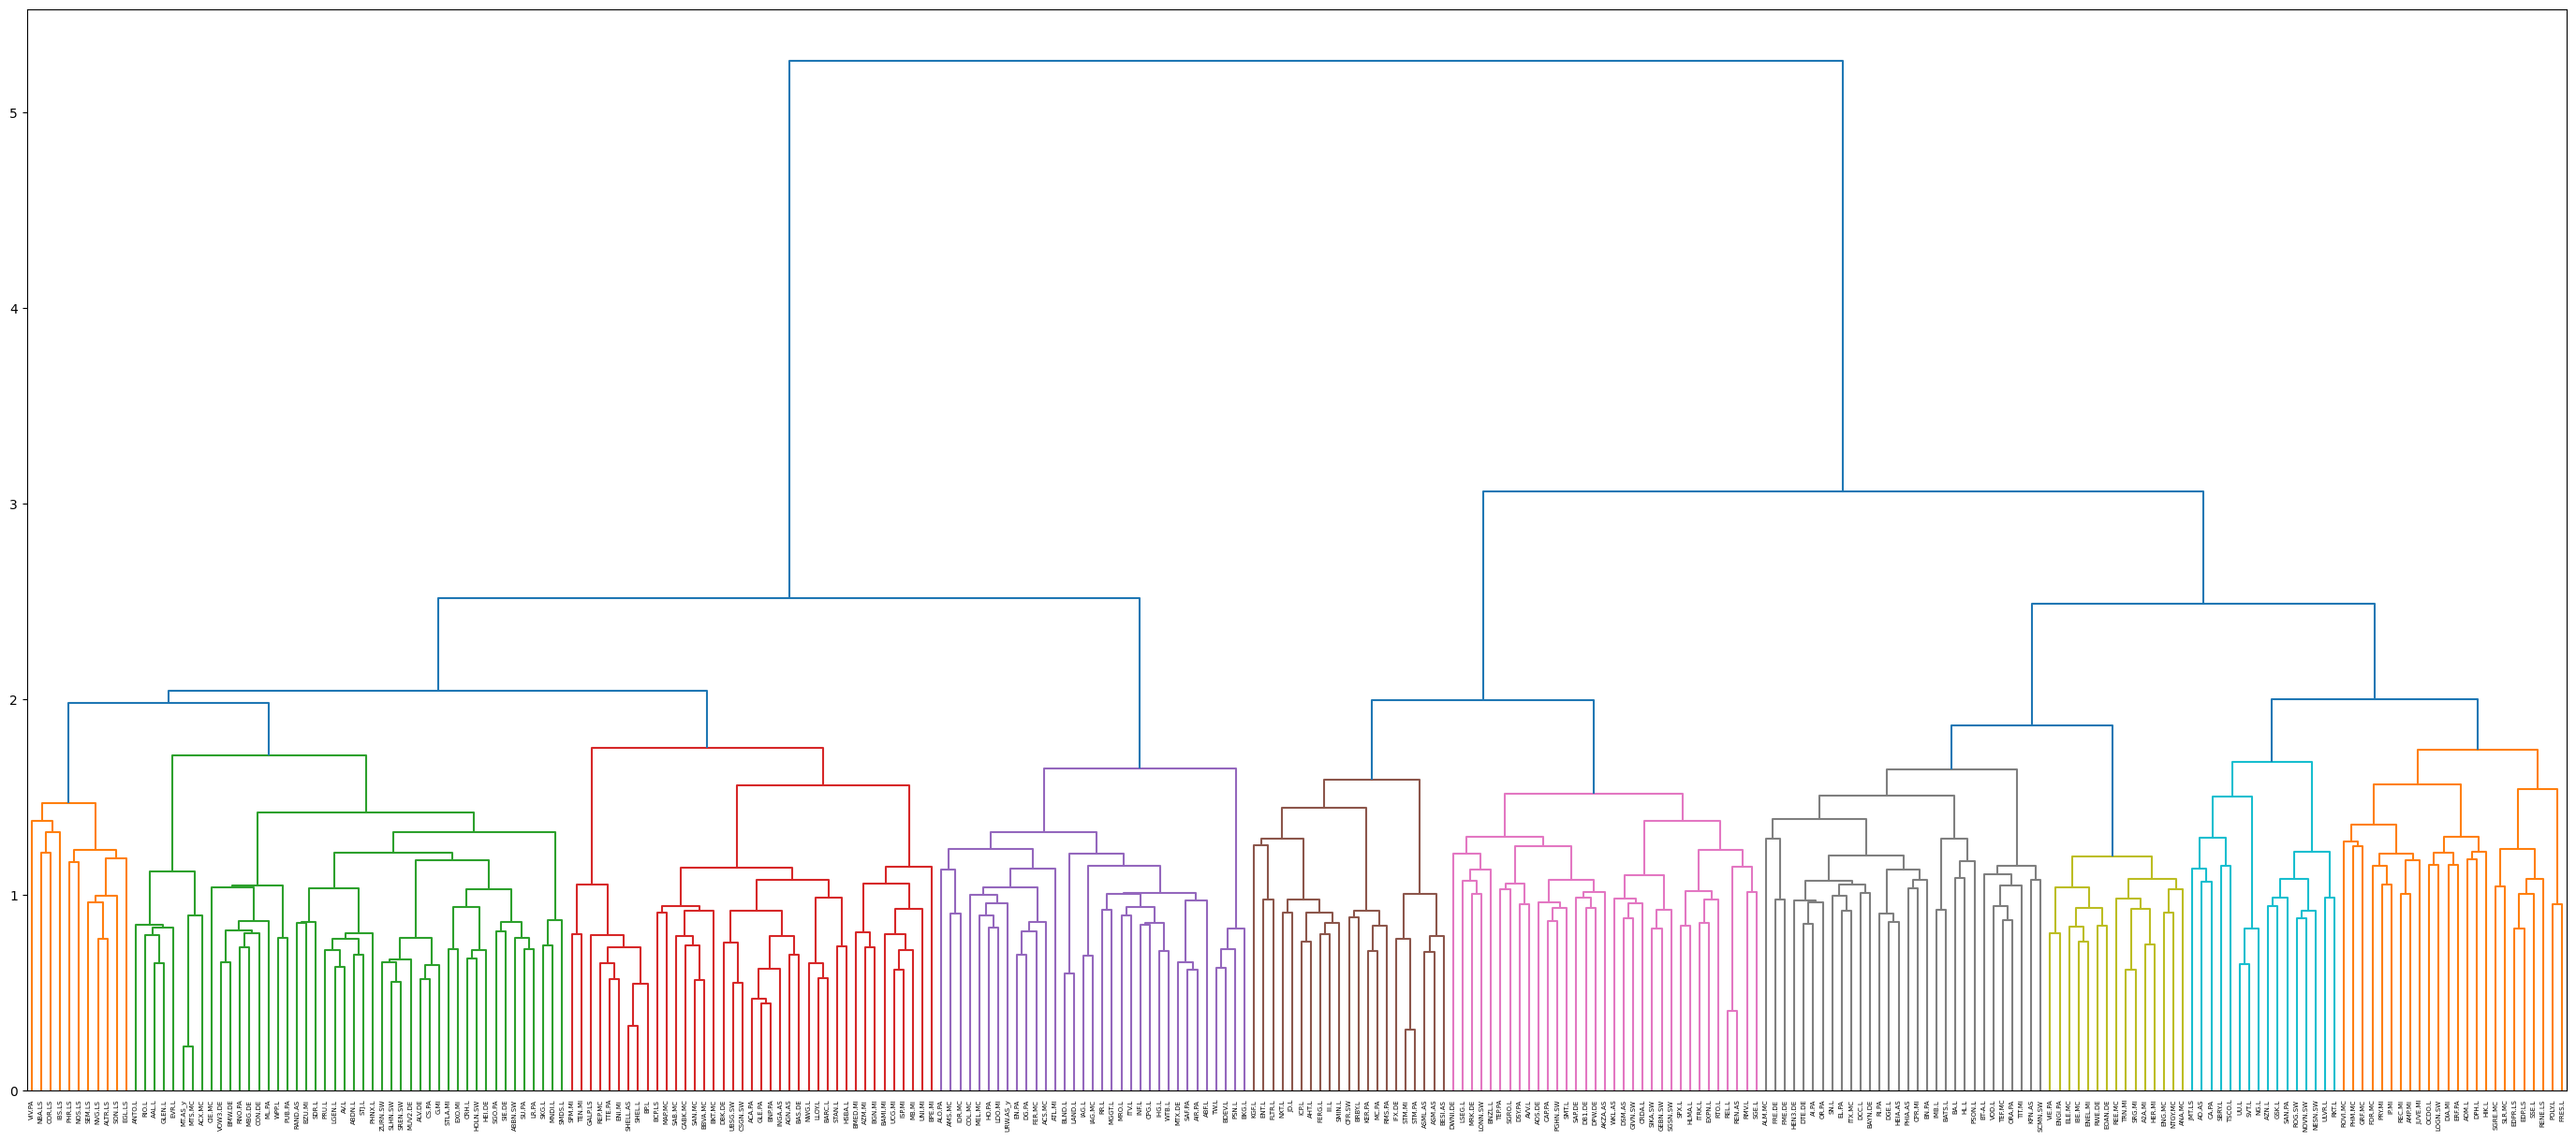

In [42]:
hacer_dendograma(ultima_ventana_european, rie_estimator.get_rie, 'ward', k_optimal_calenski_european_rie);

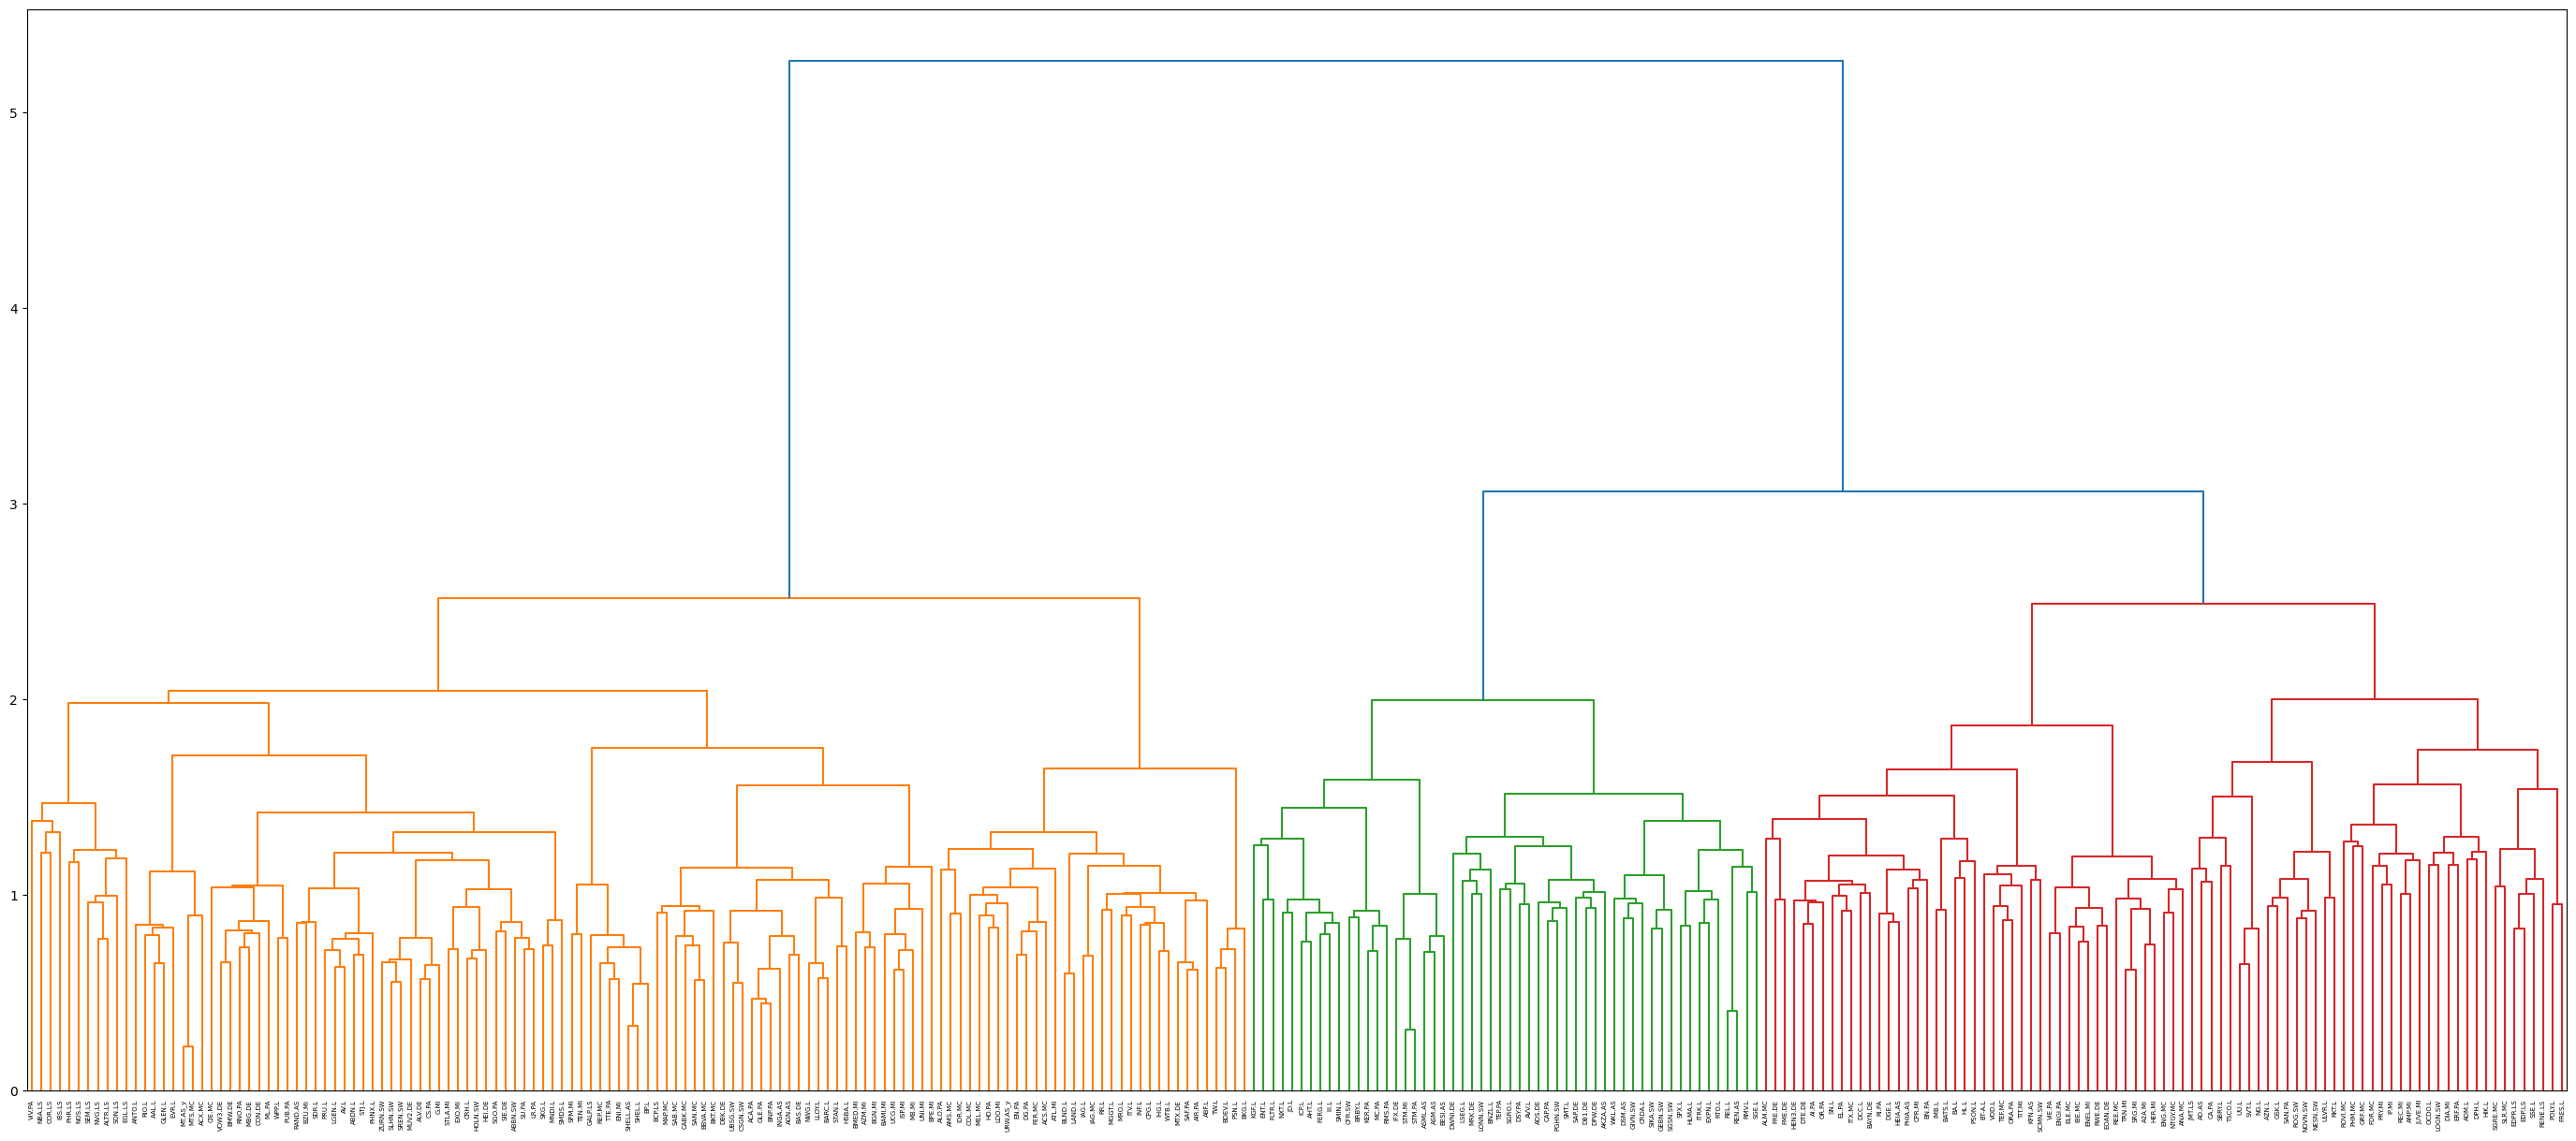

In [44]:
hacer_dendograma(ultima_ventana_european, rie_estimator.get_rie, 'ward', k_optimal_eigen_european_rie);

### ECA

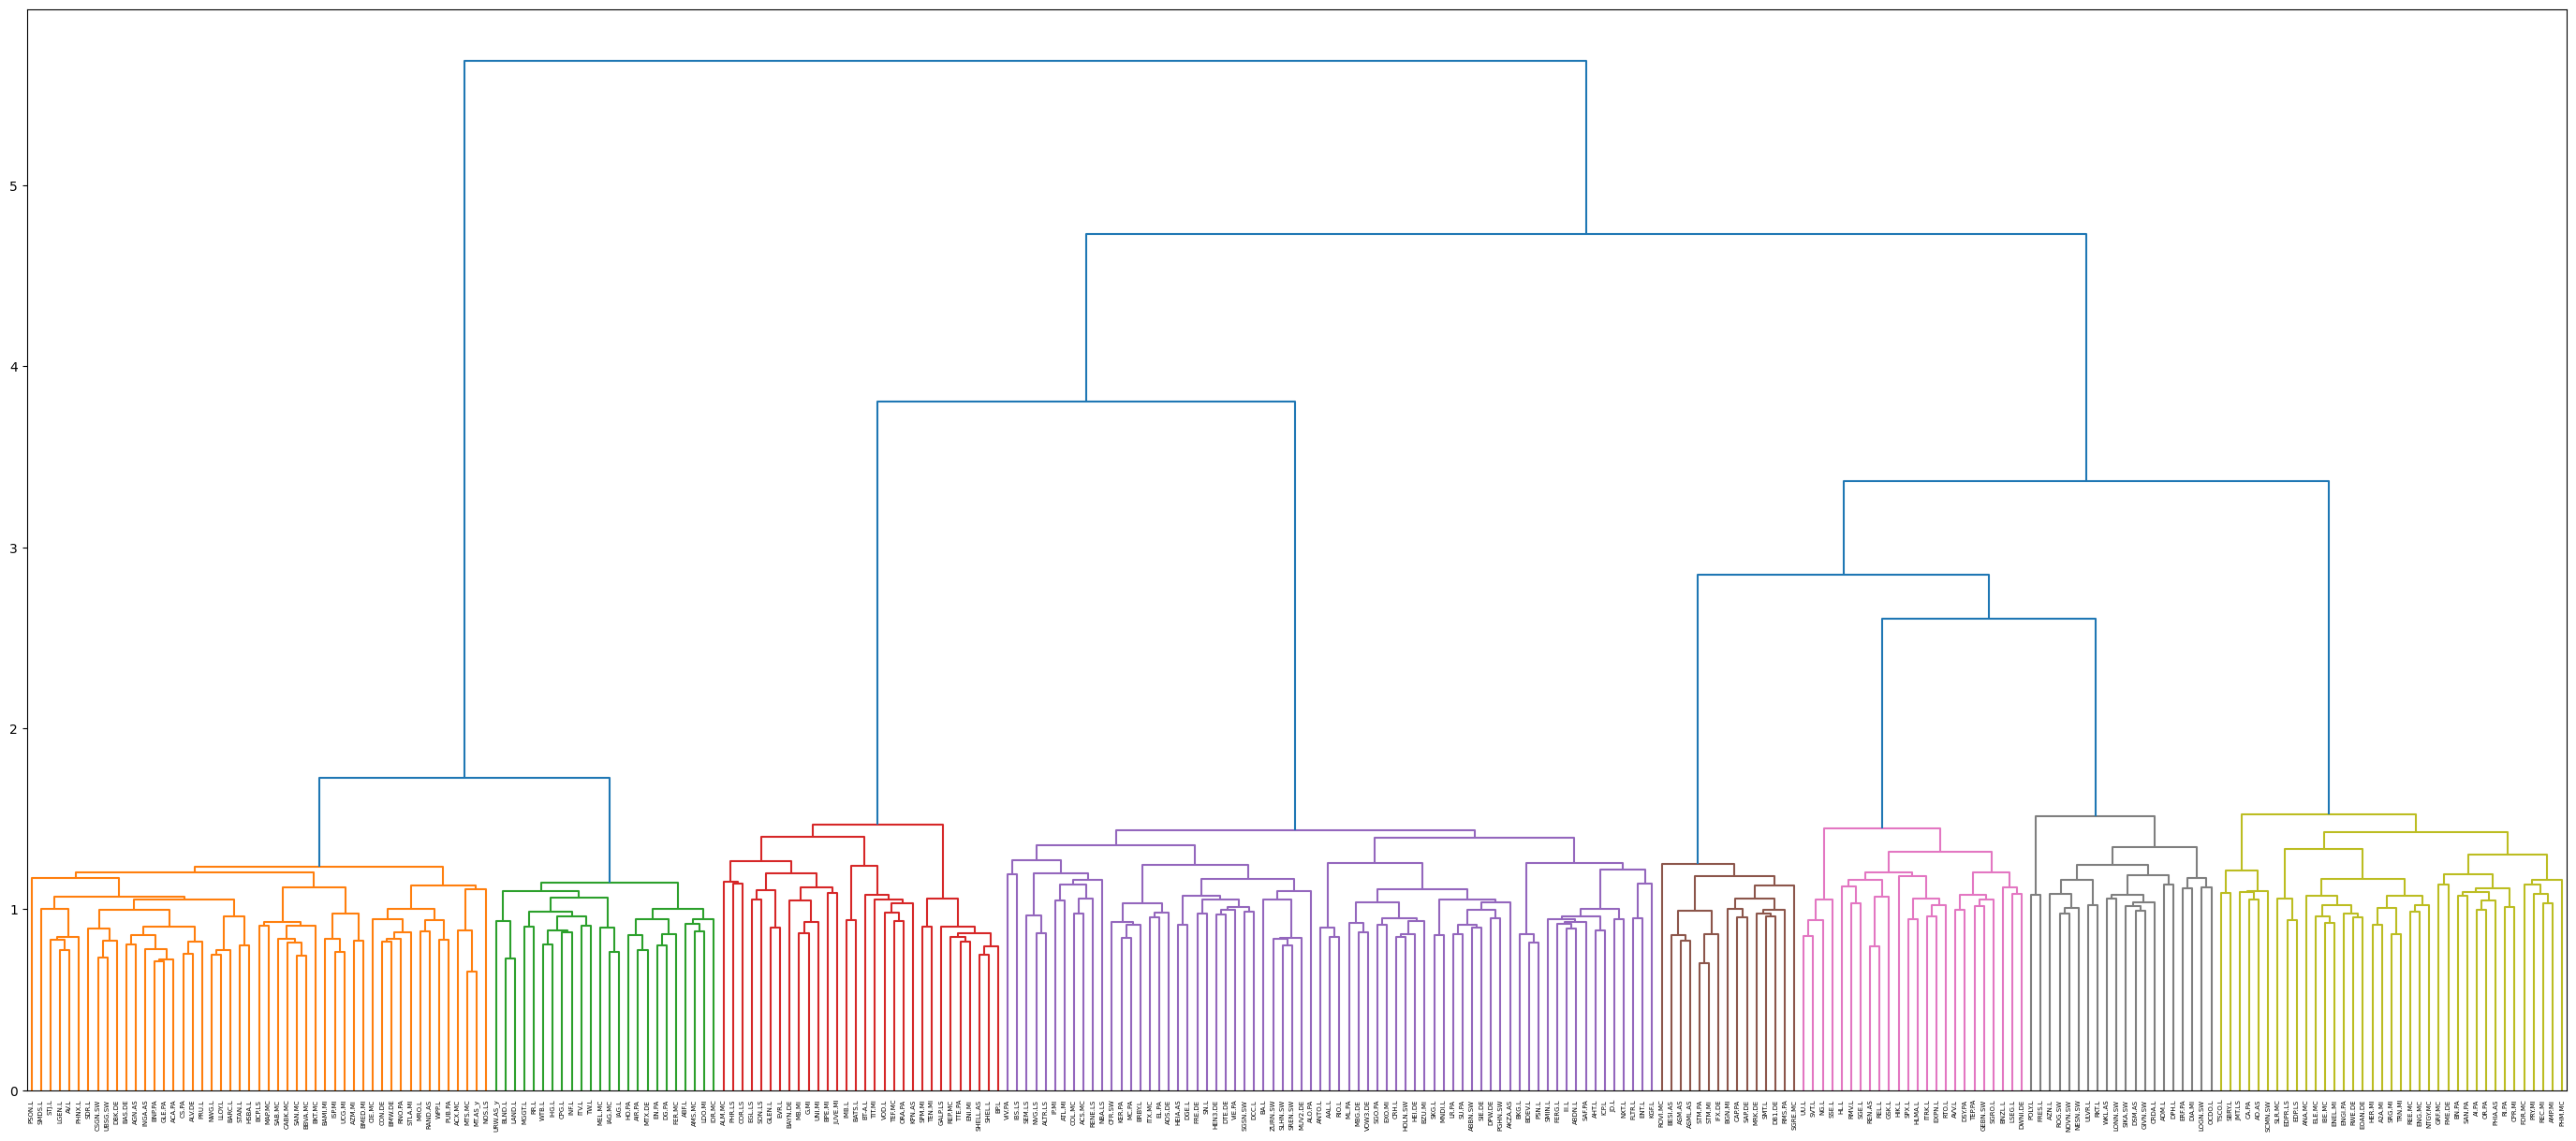

In [45]:
hacer_dendograma(ultima_ventana_european, wrapper_eca, 'ward', k_optimal_calenski_european_eca);

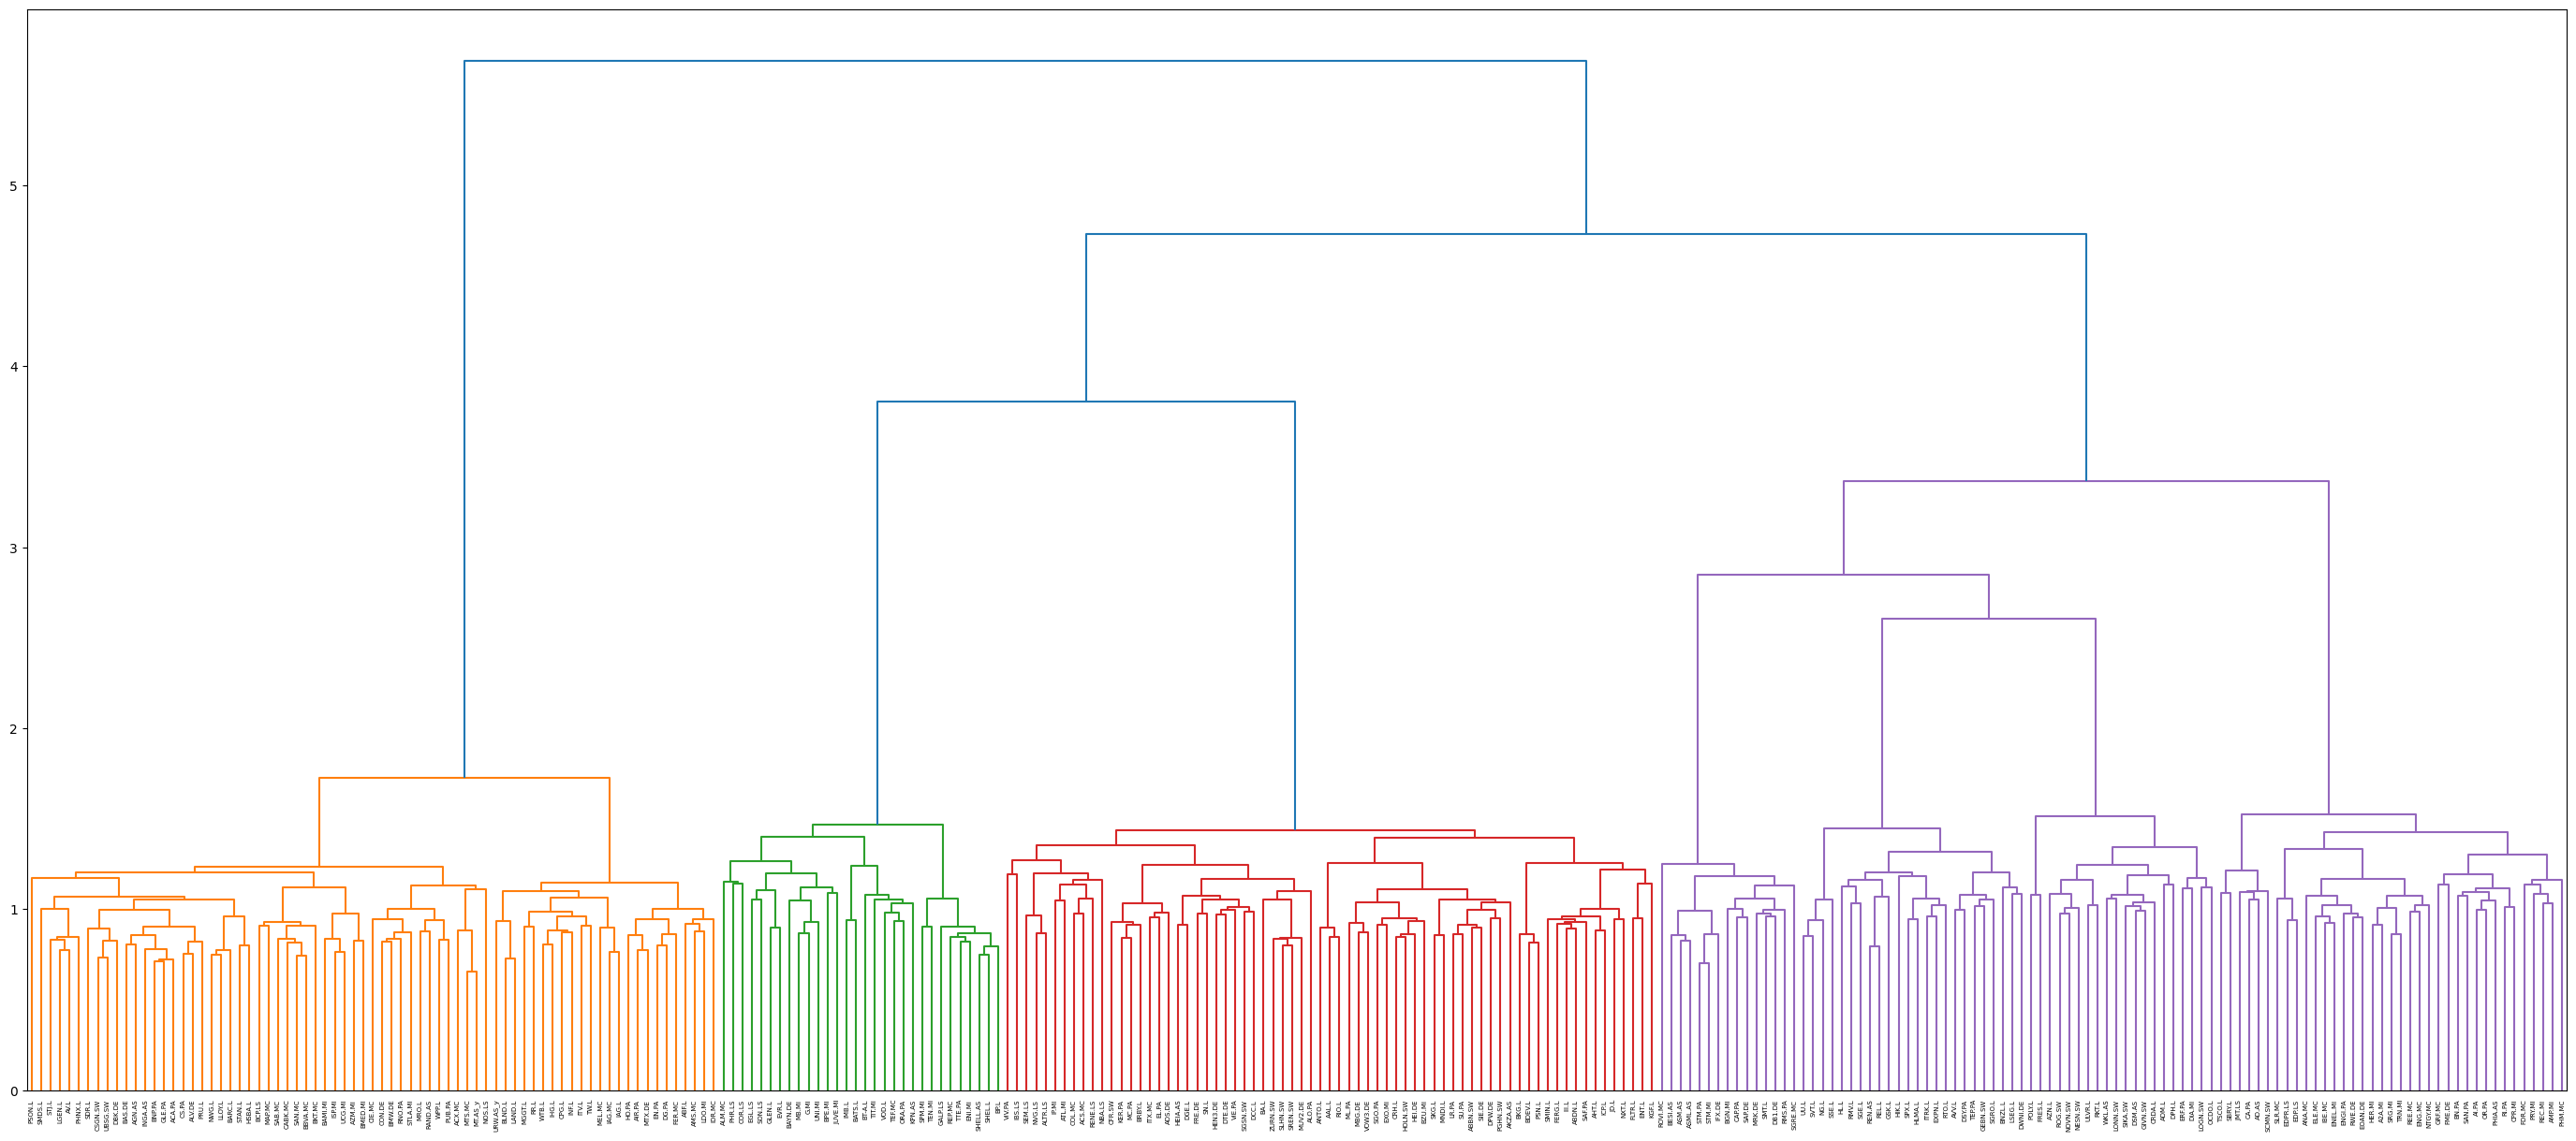

In [47]:
hacer_dendograma(ultima_ventana_european, wrapper_eca, 'ward', k_optimal_eigen_european_eca);

### PEARSON

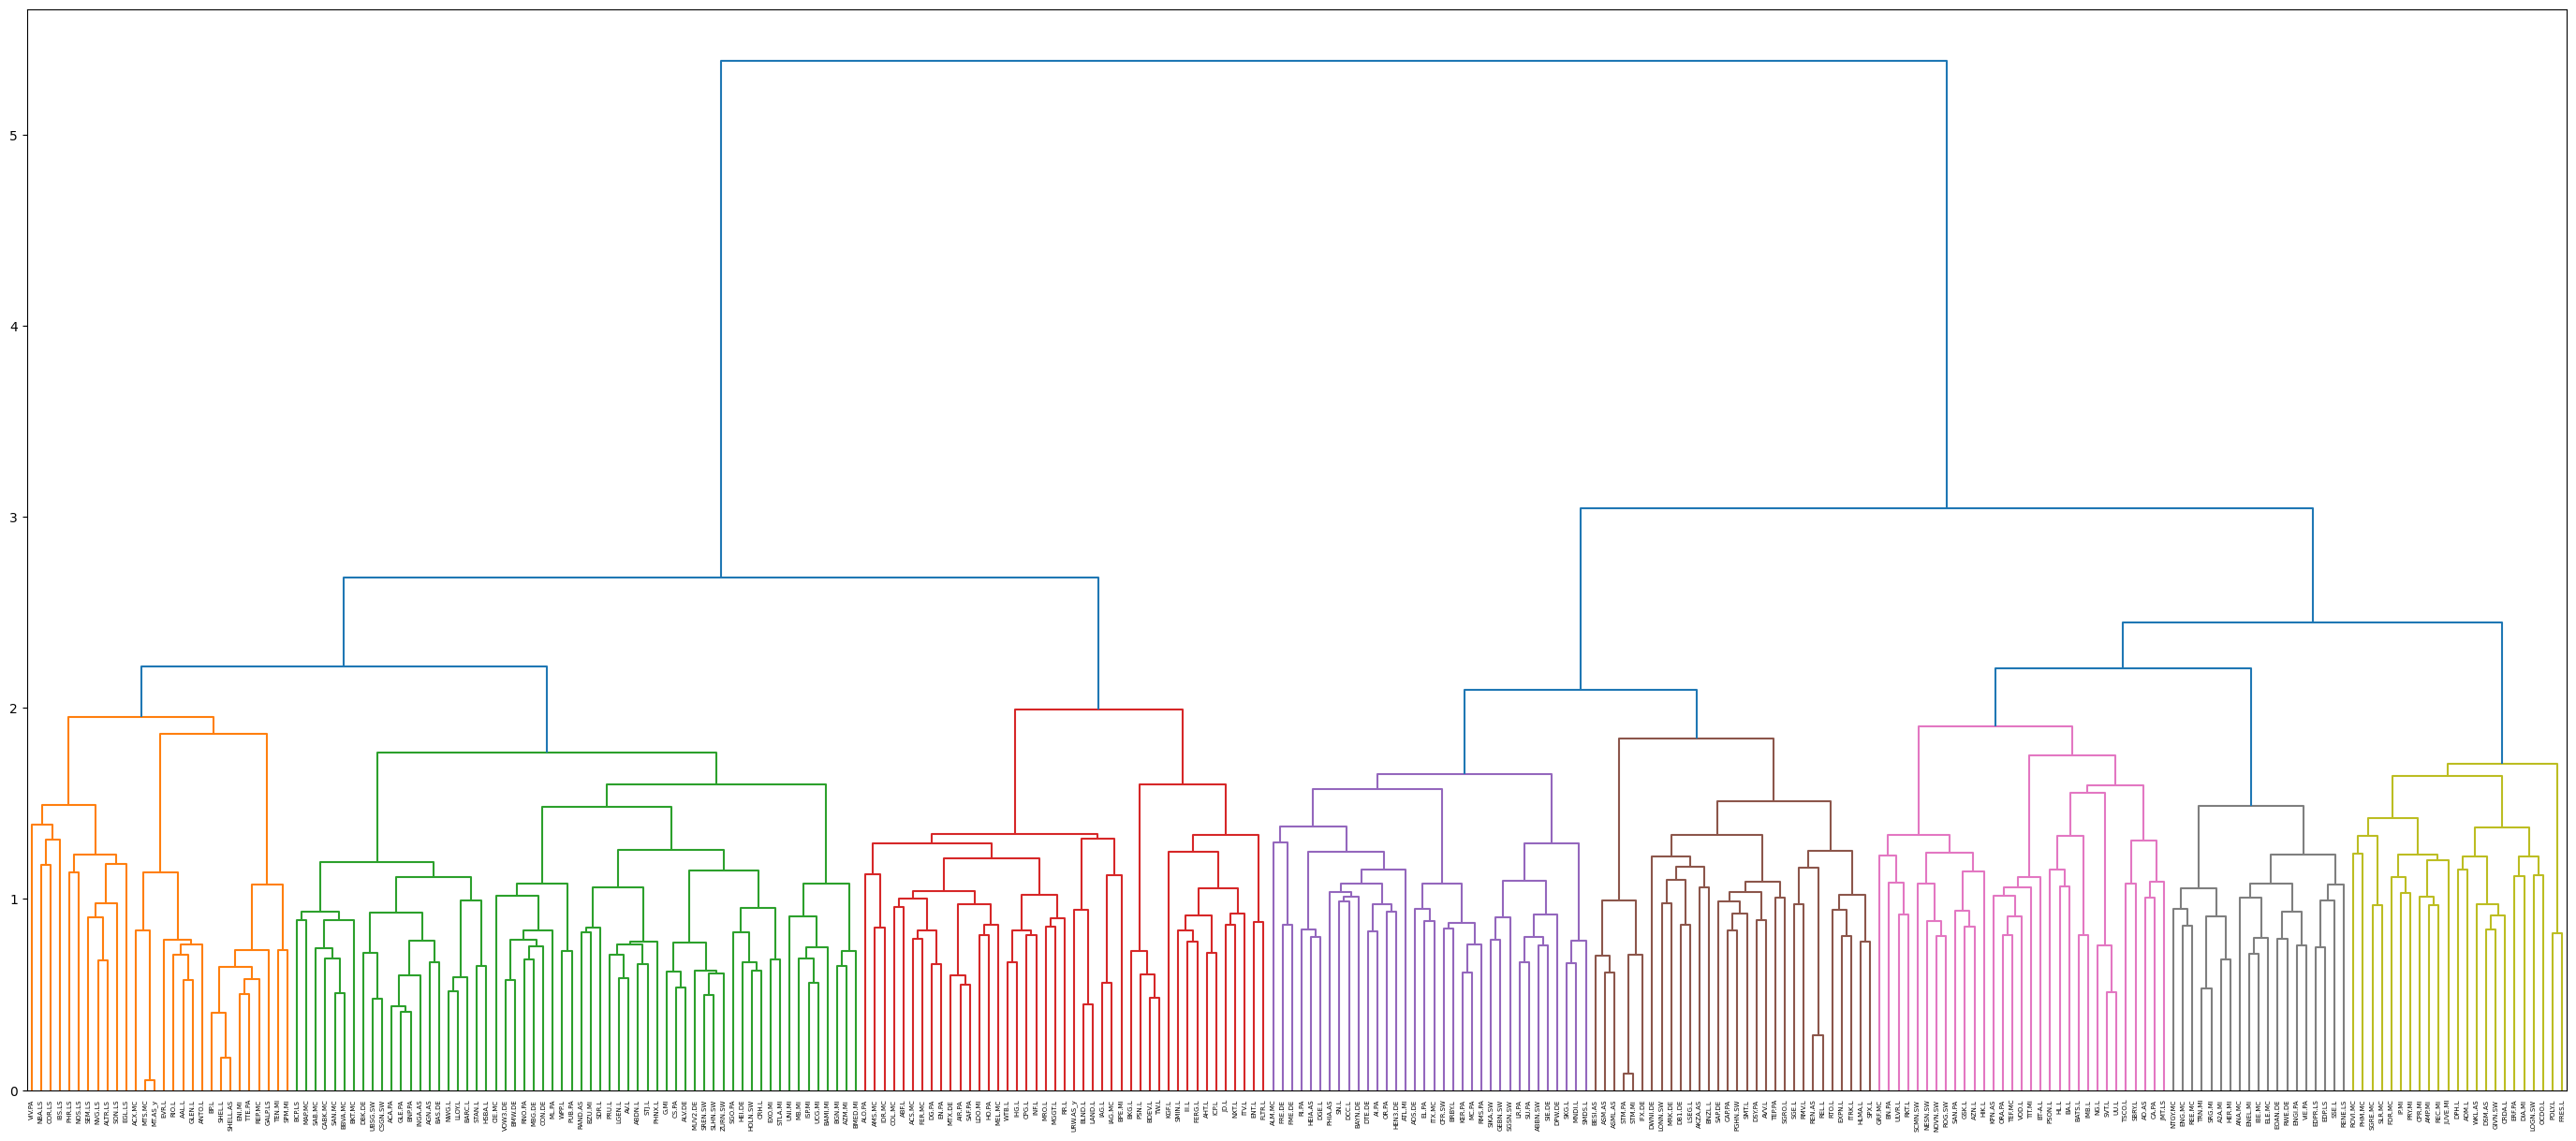

In [48]:
hacer_dendograma(ultima_ventana_european, wrapper_pearson, 'ward', k_optimal_calenski_european_pearson);

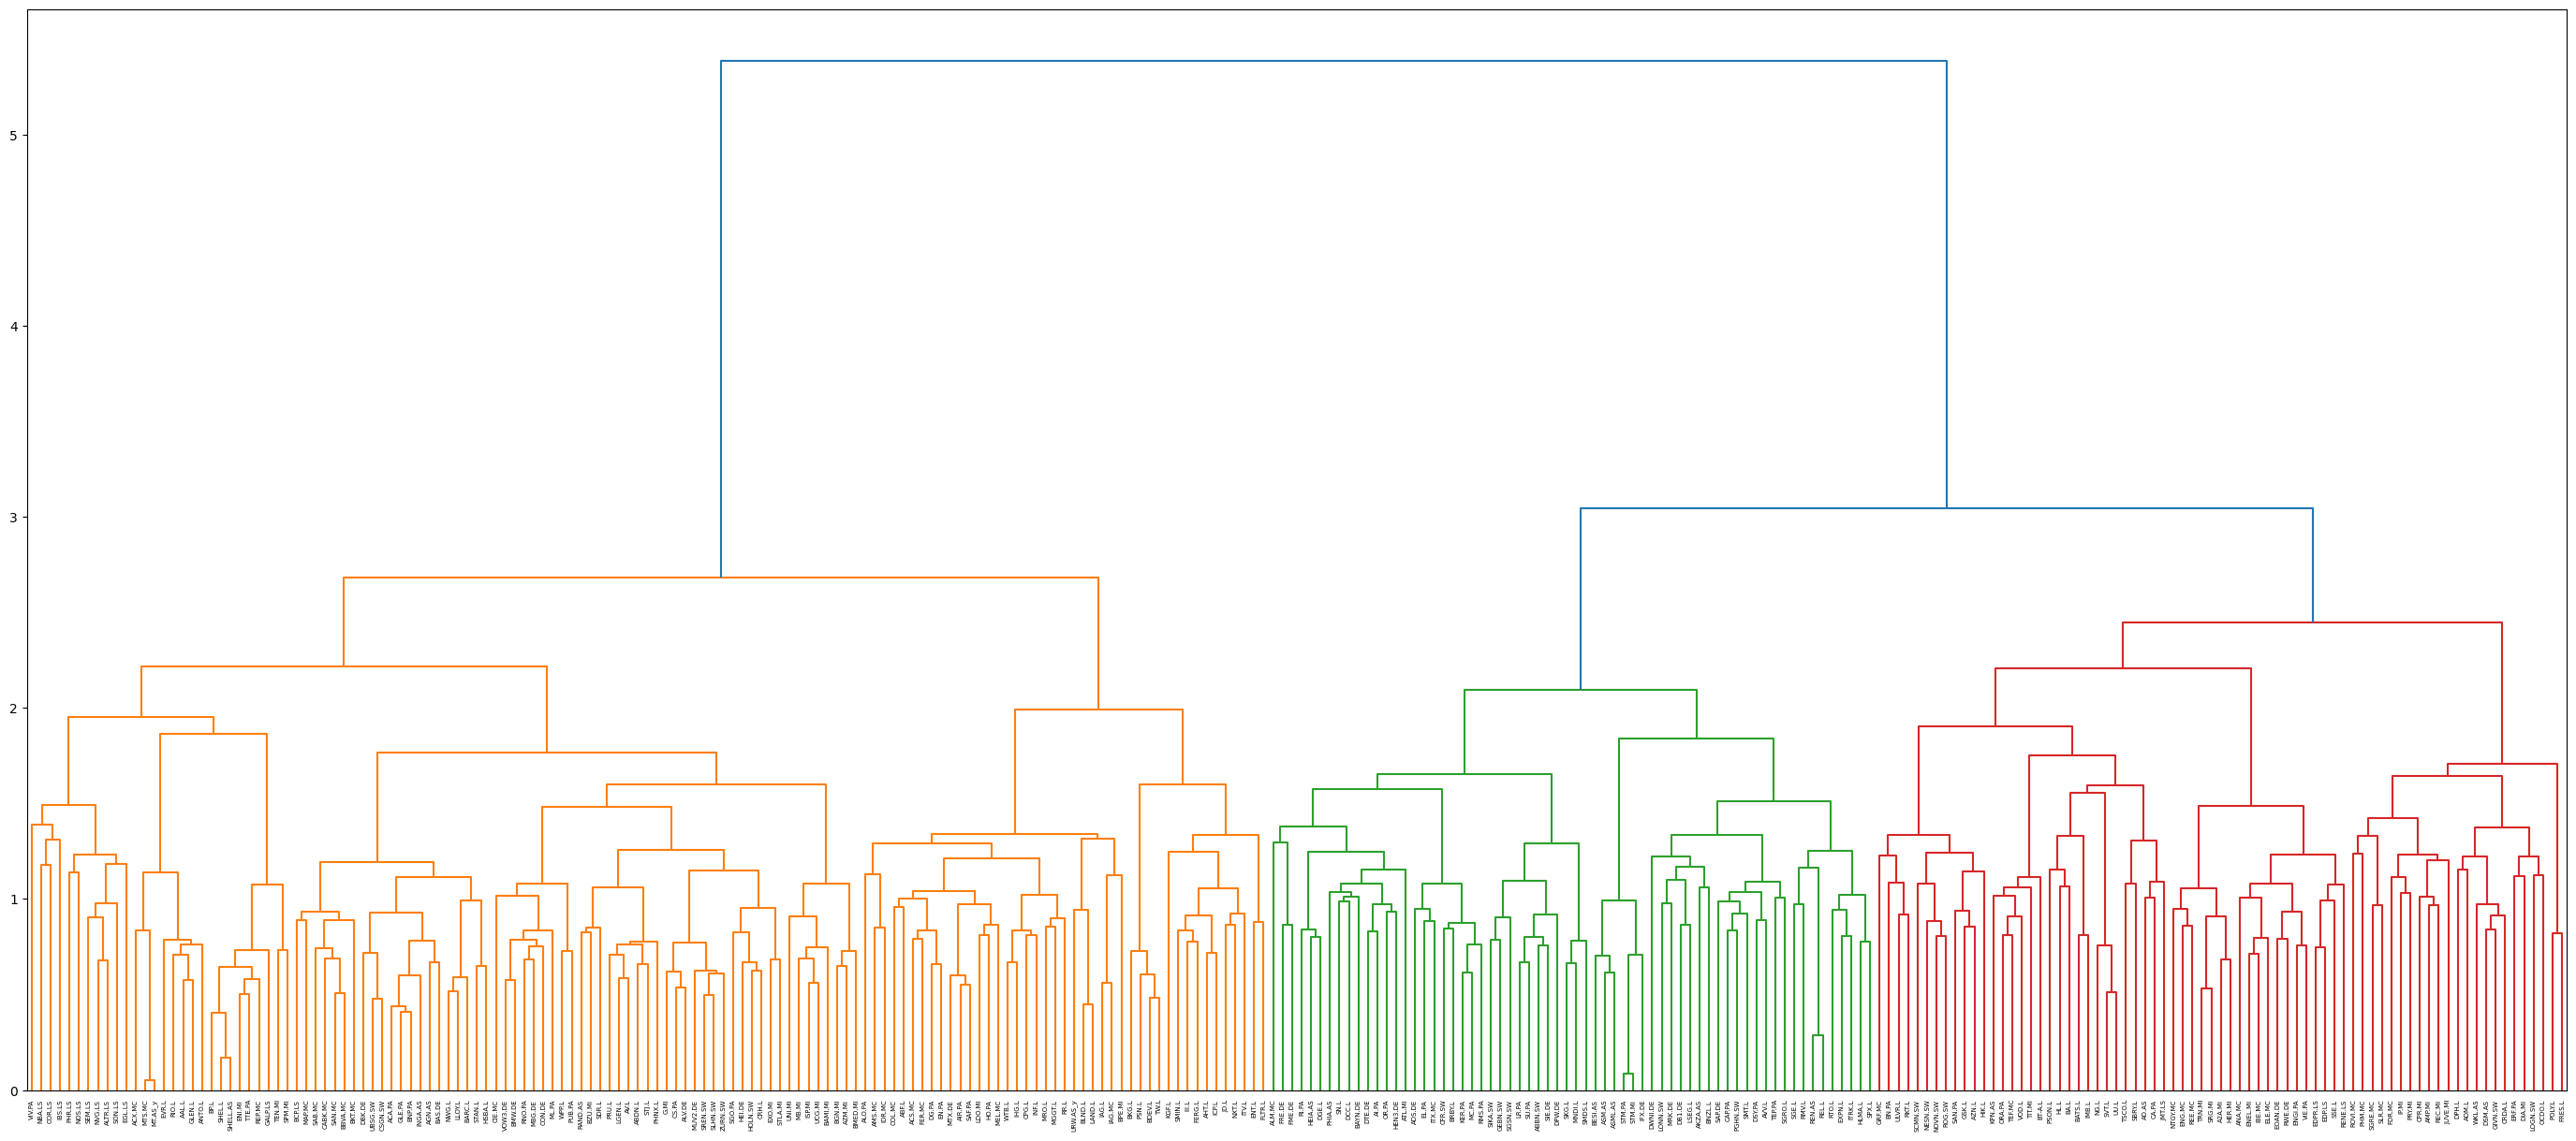

In [49]:
hacer_dendograma(ultima_ventana_european, wrapper_pearson, 'ward', k_optimal_eigen_european_pearson);

In [40]:
index, weights = hcaa_alocation(
    mat_X = ultima_ventana_american,
    n_clusters = k_optimal_calenski_american_rie,
    custom_corr=rie_estimator.get_rie,
    inverse_data=False,
)

In [61]:
ultima_ventana_american.columns

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI',
       ...
       'WYNN', 'XEL', 'XLNX', 'XOM', 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZBRA',
       'ZION'],
      dtype='object', length=460)

In [56]:
def get_jsonparsed_data(url):
    """
    Receive the content of ``url``, parse it as JSON and return the object.

    Parameters
    ----------
    url : str

    Returns
    -------
    dict
    """
    api_key = 'cc676776b8af5f3e0f2ecf4f8adabb7b'
    response = urlopen(url+'?apikey='+api_key, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

In [67]:
american_tickers = ultima_ventana_american.columns.to_numpy()

In [63]:
testin = get_jsonparsed_data("https://financialmodelingprep.com/api/v3/profile/A")

/var/folders/z2/xq98tb8d5wg4jkf4_dhj6kcc0000gn/T/ipykernel_1261/1309434272.py:14: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url+'?apikey='+api_key, cafile=certifi.where())


In [71]:
sectors = {}

Hay que hacer los request poco a poco para no sobrecargar el API. De a 150 por batch. 

No se tiene acceso a mercados europeos. 

In [76]:
for ticker in american_tickers[:150]:
    try :
        response = get_jsonparsed_data("https://financialmodelingprep.com/api/v3/profile/" + ticker)
    except:
        print('Something is wrong with the ticker' + ticker)
    
    sectors[response[0]['symbol']] = response[0]['industry']
    

/var/folders/z2/xq98tb8d5wg4jkf4_dhj6kcc0000gn/T/ipykernel_1261/1309434272.py:14: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url+'?apikey='+api_key, cafile=certifi.where())


Something is wrong with the tickerCMI
Something is wrong with the tickerCMS
Something is wrong with the tickerCNC
Something is wrong with the tickerCNP
Something is wrong with the tickerCOF
Something is wrong with the tickerCOO
Something is wrong with the tickerCOP
Something is wrong with the tickerCOST
Something is wrong with the tickerCPB
Something is wrong with the tickerCPRT
Something is wrong with the tickerCRL
Something is wrong with the tickerCRM
Something is wrong with the tickerCSCO
Something is wrong with the tickerCSX
Something is wrong with the tickerCTAS
Something is wrong with the tickerCTRA
Something is wrong with the tickerCTSH
Something is wrong with the tickerCTXS
Something is wrong with the tickerCVS
Something is wrong with the tickerCVX
Something is wrong with the tickerD
Something is wrong with the tickerDAL
Something is wrong with the tickerDD
Something is wrong with the tickerDE
Something is wrong with the tickerDFS
Something is wrong with the tickerDG
Something 

In [69]:
sectors[testin[0]['symbol']] = testin[0]['industry']

In [86]:
np.unique(np.array(list(sectors.values())), return_counts=True)

(array(['Aerospace & Defense', 'Agricultural Inputs', 'Airlines',
        'Asset Management', 'Auto Parts', 'Banks—Diversified',
        'Banks—Regional', 'Beverages—Wineries & Distilleries',
        'Business Equipment & Supplies', 'Chemicals',
        'Consumer Electronics', 'Credit Services',
        'Diagnostics & Research', 'Drug Manufacturers—General',
        'Electronic Components', 'Electronic Gaming & Multimedia',
        'Farm & Heavy Construction Machinery', 'Farm Products',
        'Financial Data & Stock Exchanges', 'Health Information Services',
        'Healthcare Plans', 'Household & Personal Products',
        'Information Technology Services', 'Insurance Brokers',
        'Insurance—Diversified', 'Insurance—Life',
        'Insurance—Property & Casualty', 'Insurance—Specialty',
        'Integrated Freight & Logistics', 'Internet Retail',
        'Medical Devices', 'Medical Distribution',
        'Medical Instruments & Supplies', 'Oil & Gas E&P',
        'Oil & Gas Equ